# Анализ поведения пользователей в мобильном приложении

### Ход исследования
1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
* задаем столбцам корректные наименования
* в столбце с действиями пользователей приведение значений `contacts_show` и `show_contacts` к единому
* проверка на дубликаты
* приведение типов данных в соответствие со значениями в столбцах
3. [Исследовательский анализ данных:](#analysis)
* [изучение данных](#learning)
* [выделение пользовательских сесиий](#sessions)
* [определение сценариев использования приложения, которые наиболее выделяются](#scenario)
* [построение воронок различных сценариев в целевое действие и расчет конверсии](#funnel)
* [проанализируем как отличается время между событиями `advert_open`->`contacts_show` и `tips_click`->`contacts_show`](#event_time)
* [определим какая конверсия в целевое действие у событий из шага, указанного выше](#conversion)
* [определим удовлетворенность пользователей приложением, посчитав их удержание - `Retention rate`](#retention)
4. [Проверка статистических гипотез:](#hypotheses)
* [конверсия в просмотры контактов различается у пользователей совершающих действия `tips_show` и `tips_click` с пользователями, совершающих только `tips_show`](#conversion_tips)
* [конверсия в просмотры различается у пользователей, совершающих действие `favorites_add` с пользователями, которые не совершают такого дейтсвия в рамках одной сессии](#conversion_favorite)
5. [Общий вывод](#conclusion)
6. [Рекомендации](#recomendation)

### Открытие данных
<a id="start"></a> 

Данные о пользователях и источниках, с которых пользователь установил приложение получим из `mobile_sources.csv.`  
Данные о действиях, которые совершали пользователи получим из ` mobile_dataset.csv`.

In [1]:
#импорт библиотек, необходимых для проведения анализа
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
from scipy import stats as st
import math as mth
from datetime import datetime, timedelta
import numpy as np

#вызываем функцию игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
#создадим переменную с расположением адреса, в котором находится выгружаемый файл на локальном компьюетере
path = 'C://Users//vladi//Downloads//'


#открываем файл с данными mobile_sources
try:
    mobile_sources = pd.read_csv(path + 'mobile_sources.csv') 
except:
    mobile_sources = pd.read_csv('https://...')


#открываем файл с данными mobile_dataset
try:
    mobile_dataset =  pd.read_csv(path + 'mobile_dataset.csv') 
except:
    mobile_dataset = pd.read_csv('https://...')
      
    
#выведем на экран первые 5 строк, выгруженных датасетов
display(
    mobile_sources.head(),
    mobile_dataset.head()
)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Основа я работа будет с файлом `mobile_dataset`, в котором отображены действия пользователей приложения. Поэтому работу начнем с него. **Здесь и далее будут описываться действия именно с этим файлом.**

О качестве данных ничего неизвестно, поэтому перед тем как приступать к целям исследования, требуется их обзор и предобработка. Сперва изучим общую информацию о датасете:

In [3]:
#изучим общую информацию о датасете
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Всего в выгруженном датасете 74 197 действий.  
Пропусков в данных нет.  
Тип данных столбца `event.time` не соответствует его значениям.
Требуется изменение наименований столбцов для дальнейшей работы с ними (чтобы не возникали ошибки в коде при обращении к ним).

В связи с этим переходим к этапу предобработки данных.

### Предобработка данных
<a id="preprocessing"></a> 

Сперва зададим столбцам корректные наименования:

In [4]:
#зададим столбцам корректные наименования
mobile_dataset = mobile_dataset.rename(
    columns={
        'event.time':'event_time',
        'event.name':'event_name',
        'user.id':'user_id'
    }
)

#выведем полученные наименования столбцов
list(mobile_dataset)

['event_time', 'event_name', 'user_id']

Наименования столбцов преобразованы.  

В описании данных указано, что в столбце с видами действий `event_name` событие просмотр контактов записано под двумя наименованиями `contacts_show` и `show_contacts`. Такое могло произойти, когда данные выгружались из разных баз и в разных базах наименования данного действия были задаными по-разному.  
Сперва проверим так ли это:

In [5]:
#выведем уникальные значения дейстий пользователей
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Информация подтвердилась: есть и `contacts_show`, и `show_contacts.`   
Для дальнейшей работы приведем все наименования данного действия (просмотр контактов) к одному наименованию - `contacts_show`:

In [6]:
#методом replace заменим в столбце event_name все строки со значениями show_contacts на значения contacts_show
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace('show_contacts', 'contacts_show')

#выведем полученные уникальные значения действий
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

Замена произведена. Теперь просмотр контактов только под наименованием `contacts_show`.

Удалим явные дубликаты, елси они есть:

In [7]:
#избавимся от явных дубликатов методом drop_duplicates
mobile_dataset = mobile_dataset.drop_duplicates()

#выведем количество строк датасета после удаления дубликатов
len(mobile_dataset)

74197

Длина датасета не изменилась, значит явные дубликаты отсутствовали.  
Проверка на неявные дубликаты в данном случае не имеет смысла, т.к. время, ID пользователя и типы действий в совокупности по строкам уникальны.

В данных со временем отображены миллисекунды, для анализа они нам не потребуются (достаточно времени указанного до секунд, т.к. в данном исследовании не требуется высокая точность), избавимся от них:

In [8]:
#перезапишем столбец event_time оставив в нем дату и время без миллисекунд 
mobile_dataset['event_time'] = mobile_dataset['event_time'].astype('datetime64[s]')
display(
    #выведем 1-ю строку измененного столбца
    mobile_dataset['event_time'].head(1),
    #выведем типы данных преобразованного датасета
    mobile_dataset.dtypes
)

0   2019-10-07
Name: event_time, dtype: datetime64[ns]

event_time    datetime64[ns]
event_name            object
user_id               object
dtype: object

От миллисекунд избавились.

После проведенного округления колонки `event_time` проверим датафрейм еще раз на дубликаты:

In [9]:
#приведем значения столбца event_time к типу данных, обозначающих время, вызвав pd.to_datetime
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

In [10]:
#посчитаем количество дубликтов
mobile_dataset.duplicated().sum()

1143

Количество дубликатов увеличилось. Избавимся от них:

In [11]:
#избавимся от явных дубликатов методом drop_duplicates и перезапишем индексы
mobile_dataset = mobile_dataset.drop_duplicates().reset_index(drop=True)

Предобработка данных завершена. Переходим к анализу данных.

### Исследовательский анализ данных
<a id="analysis"></a> 

#### Изучение данных
<a id="learning"></a> 

**Сперва посмотрим сколько всего событий в логе:**

In [12]:
#построим сводную таблицу, сгруппировав по столбцу event_name и выведем количество каждого
events_count = mobile_dataset.pivot_table(
    index = 'event_name',
    aggfunc = 'count',
    margins = 'All' #выведем итоговую сумму, чтобы проверить себя, что мы не ошиблись в вычислениях, общее кол-во строк должно
)[                  #получиться равное количеству строк датафрейма или 74 197
    'user_id'
].reset_index(
).rename(
    columns={'user_id' : 'count'} #переименуем колонку
).sort_values( #отсортируем данные по столбцу count в порядке убывания
    by='count', ascending=False
).reset_index(drop=True) #перезапишем индексы

#добавим еще один столбец с расчетом доли каждого события,
#поделив каждое значение на первое, в которои саккмлировано все их количество и окргулив до 1 знака после запятой
events_count['event_part_%'] = round(events_count['count'] / events_count['count'].loc[0] * 100, 1)

#выведем полученную таблицу
events_count

,event_name,count,event_part_%
0,All,73054,100.0
1,tips_show,39907,54.6
2,photos_show,9352,12.8
3,advert_open,6146,8.4
4,contacts_show,4376,6.0
5,map,3749,5.1
6,search_1,3488,4.8
7,favorites_add,1414,1.9
8,search_5,1049,1.4
9,tips_click,811,1.1


Визуализируем полученные данные с помощью столбчатой диаграммы:

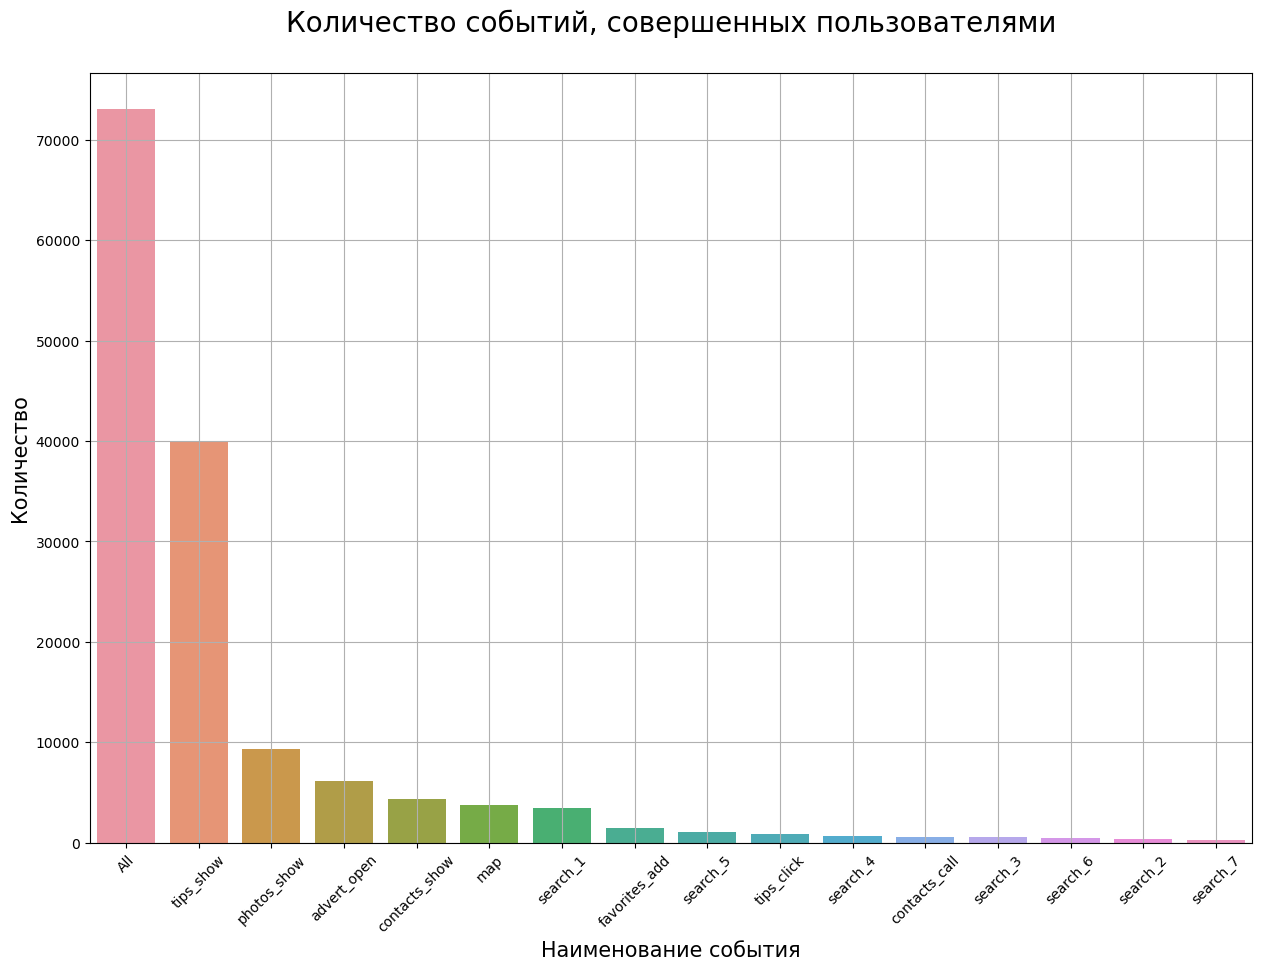

In [13]:
#построим столбчатую диаграмму по количсетву событий

#зададим размер графика
plt.figure(figsize=(15,10))

sns.barplot(
    data=events_count,
    x='event_name', #по оси х отложим наименования событий
    y='count' #по оси у - количество событий
)

#зададим сетку
plt.grid() 

#задаем цветовую палитру
sns.set_palette('pastel')

#поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)

#формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Количество событий, совершенных пользователями\n', fontsize=20)
plt.xlabel('Наименование события', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Из полученных таблицы и графика видно, что всего 16 действий, которые совершает пользователь. Больше всего событий tips_show - пользователь увидел рекомендованное объявление - 54% или больше половины всех событий. Это объяснимо, ведь показ рекомендаций происходит независимо от действий пользователя. А вот кликов по рекомендованным объявлениям нетак много (tips_click) их доля составляет 1,1%.

Следующим по количеству является событие просмотра фото (photos_show) - 12,8%. Это в связи с тем, что пользователь листает фотографии, когда ему приглянулось какое-либо объявление.

Следующим по событийности действие - открыл карточки объявления (advert_open) - 8,4%. Если пользователя заинтересовало объявление, то он в него проваливается.

Доля целевого действия в просмотр контактов (contacts_show) идет следующим за событием просмотра карточек и составляет 6,1%.

Также можно сделать вывод, что пользователи довольно неплохо используют карту объявлений (map) - 5,2%. Также пользователи нетак активно используют действие добавления объявление в избранное (favorites_add) - 1,9%. Звонят по объявлению посредством приложения крайне редко (contacts_call) - 0,7%.

Остальные действия приходятся на поиск объявлений и наиболее популярен первый поиск (search_1) - 4,7%.

**Посмотрим какое количество уникальных пользователей в рассматриваемом периоде:**

In [14]:
#посчитаем количество уникальных пользователей методом nunique
mobile_dataset['user_id'].nunique()

4293

Всего 4 293 уникальных пользователя за 4 недели.

**Посчитаем сколько в среднем событий приходится на пользователя.**  

Т.к. один пользователь может совершать очень много действий, а другой очень мало, то брать за среднее количество событий, совершаемых пользователем, показатель среднего арифметического будет некорректным. Поэтому рассмотрим среднее значение при помощи построения гистограммы и расчета медианного значения:

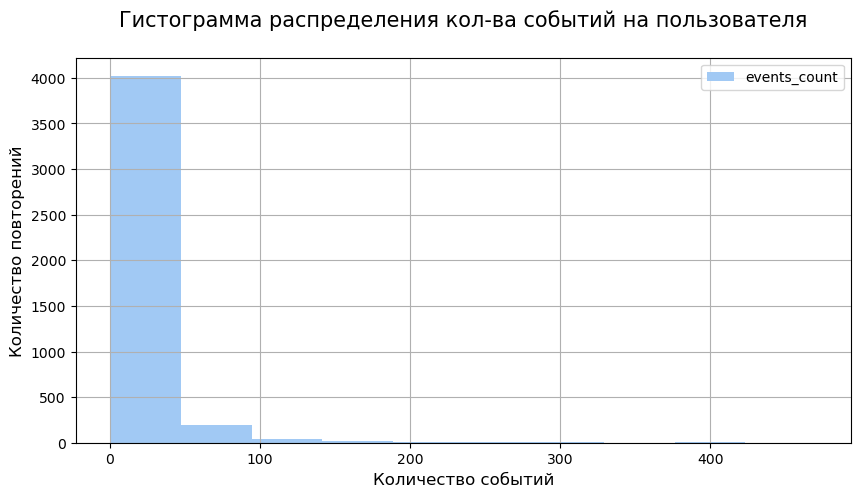

In [15]:
grouped_events_per_user = mobile_dataset.groupby( #сгруппируем датасет по пользователям
    'user_id', as_index=False
)['event_name'].count( #посчитав сколько событий приходится на каждого пользователя
).rename(
    columns={'event_name':'events_count'}
).drop(
    ['user_id'], axis=1
)

grouped_events_per_user.plot(
    kind='hist', #построим гистограмму
    legend=True,
    figsize=(10,5),
    grid=True,
)

#зададим наименования графика
plt.title('Гистограмма распределения кол-ва событий на пользователя\n', fontsize=15)

#подпишем оси графика
plt.xlabel('Количество событий', fontsize=12)
plt.ylabel('Количество повторений', fontsize=12);

В таком формате гистограмма не наглядна и ее сложно интерпритировать, т.к. большое скопление данных в районе от 0 до 50 количеств событий на 1 пользователя и очень длинный хвост в сторону редкого количества событий на одного пользователя в размере 500. Построим диаграмму "ящика с усами" для наглядности:

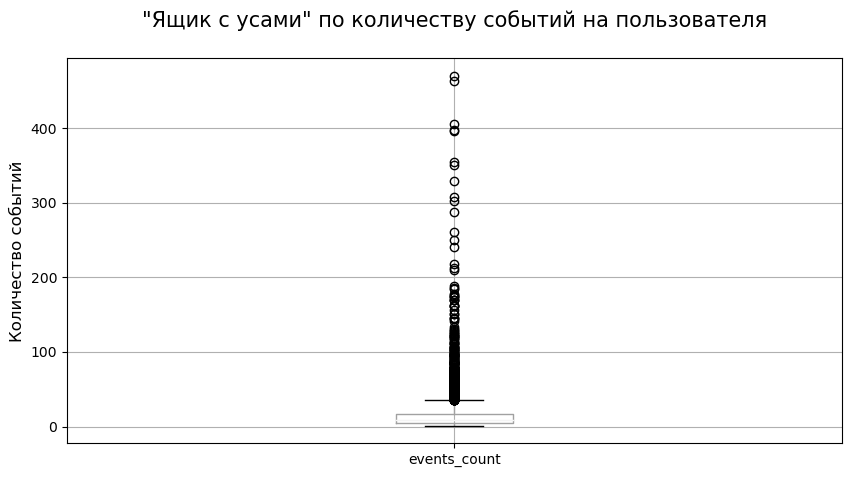

In [16]:
#построим "ящик с усами"
grouped_events_per_user.boxplot(figsize=(10,5))

#зададим наименования графика
plt.title('"Ящик с усами" по количеству событий на пользователя\n', fontsize=15)

#подпишем ось y
plt.ylabel('Количество событий', fontsize=12);

Из диаграммы размаха видно, что есть ряд очень активных пользователей, совершивших свыше 200 действий. Основная часть пользователей с повторяющимся количеством событий расположена от 200 и ниже.

Для более детального анализа приблизим диаграмму, изменив ее масштаб по оси у:

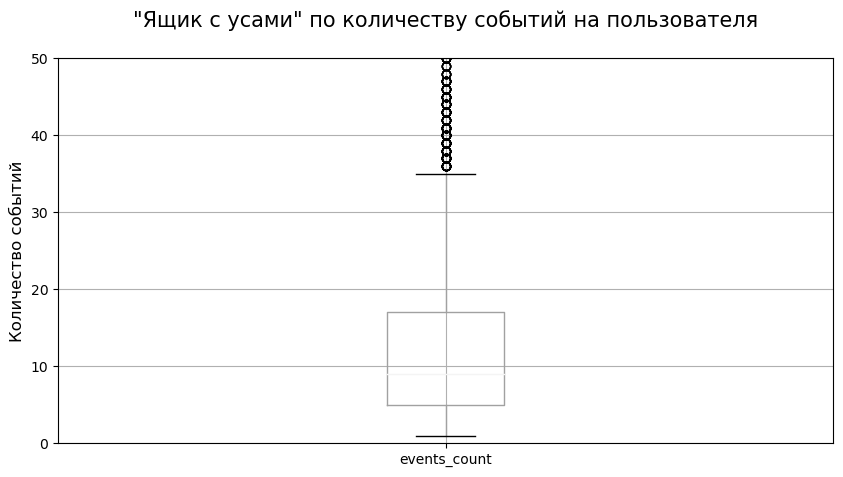

In [17]:
#построим "ящик с усами"
grouped_events_per_user.boxplot(figsize=(10,5))

#зададим масштаб по оси у до 50 событий
plt.ylim(0,50)

#зададим наименования графика
plt.title('"Ящик с усами" по количеству событий на пользователя\n', fontsize=15)

#подпишем ось y
plt.ylabel('Количество событий', fontsize=12);

При таком представлении визуализации видим, что медианное значение количества событий на пользователя в районе 10.

Построим еще раз гистограмму, но уже также поменяем границы рассматриваемого интервала количества событий на одного пользователя (от 0 до 100) и добавим "корзин":

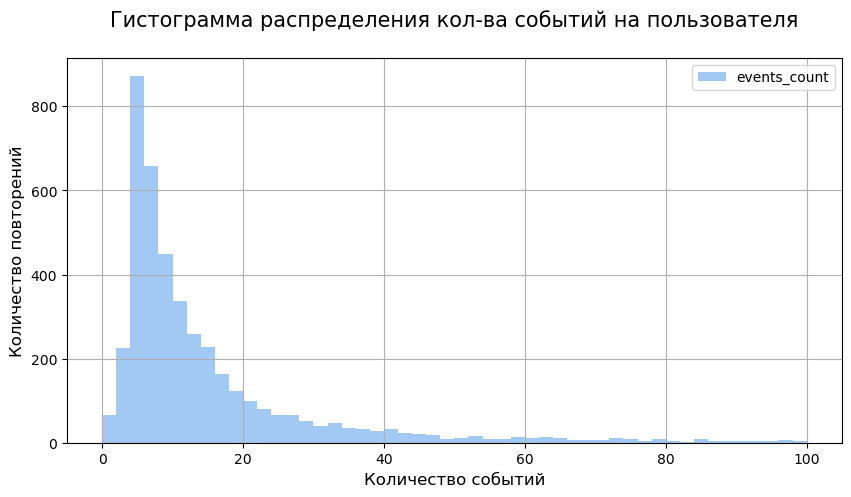

In [18]:
grouped_events_per_user.plot(
    kind='hist', #построим гистограмму
    legend=True,
    figsize=(10,5),
    grid=True,
    range=(0,100), #изменили рассматриваемое количество событий
    bins=50 #задали количество корзин
)

#зададим наименования графика
plt.title('Гистограмма распределения кол-ва событий на пользователя\n', fontsize=15)

#подпишем оси графика
plt.xlabel('Количество событий', fontsize=12)
plt.ylabel('Количество повторений', fontsize=12);

На данной гистограмме уже лучше видно распределение количества событий на пользователя. И можно предположить, что медианное значение расположено в районе 8 повторений на одного пользователя. Проверим - посчитаем медиану:

In [19]:
#рассчитаем медианну
grouped_events_per_user.median()

events_count    9.0
dtype: float64

**Таким образом в среднем на одного пользователя приходится 9 событий.**

С общей информацией ознакомились, приступим к выделению пользовательских сессий.

**Рассмотрим за какой период представлены данные:**

In [20]:
#выведем описание данных столбца event_time с помощью функции 
mobile_dataset['event_time'].describe()

count                   73054
unique                  71291
top       2019-10-22 13:00:04
freq                        4
first     2019-10-07 00:00:00
last      2019-11-03 23:58:12
Name: event_time, dtype: object

Исследуемый период с 7 октября 2019 г. по 3 ноября 2019 г. или ровно 4 недели.

**Построим график количества событий по дням:**

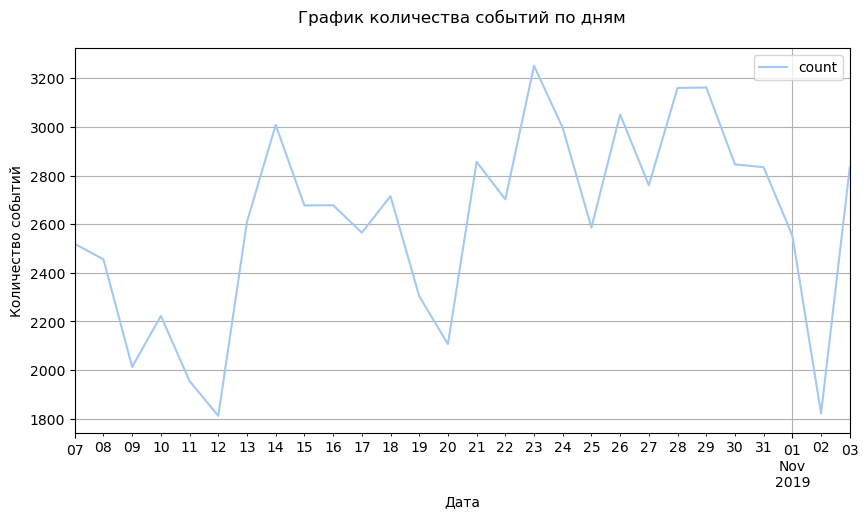

In [21]:
#добавим столбец event_date, в котором будет отображены только дата вычлененная из столбца event_ts
mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date

#преобразуем тип данных столбца event_date в datetime
mobile_dataset['event_date'] = pd.to_datetime(mobile_dataset['event_date'])

mobile_dataset.groupby(
    'event_date' #сгруппируем данные по датам
).agg(
    {'event_name' : 'count'} #посчитаем количество событий на каждую дату
).rename(  #переименуем столбец
    columns={'event_name' : 'count'}
).plot(
    kind='line',
    figsize=(10,5),
    grid=True,
    xlabel='Дата',
    ylabel='Количество событий',
    title='График количества событий по дням\n'
);

В целом график нестабилен: есть то резкие всплески событий, то наоборот, просмотры падают. Может быть, это зависит от дня недели. Проверим это:

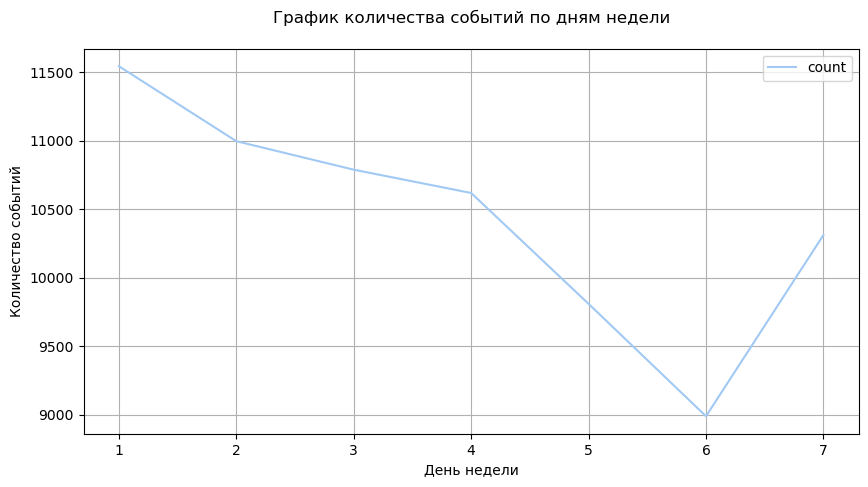

In [22]:
#добавим в датасет столбик weekday, в котором отобразим дни недели в зависимости от даты
mobile_dataset['weekday'] = mobile_dataset['event_time'].dt.weekday

#добавим 1 ко всем значениям, в полученном столбце, чтобы легче было воспринимать дни недели,
#чтобы понедельник был под 1, а воскресенье под 7
mobile_dataset['weekday'] = mobile_dataset['weekday'] + 1

mobile_dataset.groupby(
    'weekday' #сгруппируем данные по дням недели
).agg(
    {'event_name' : 'count'} #посчитаем количество событий на каждый хдень недели
).rename(  #переименуем столбец
    columns={'event_name' : 'count'}
).plot(
    kind='line',
    figsize=(10,5),
    grid=True,
    xlabel='День недели',
    ylabel='Количество событий',
    title='График количества событий по дням недели\n'
);

Видим, что больше всего просмотров приходится на пн, к концу недели идет спад по просмотрам, с пятницы на субботу самый большой провал. Возможно, это связано с тем, что по будням многие регулярно осуществляют просмотр объявлений после работы, но в пятницу люди могут провести вечер вне дома, занимаясь досугом, в субботу тоже.


Посмотрим также сколько в среднем событий приходится на день:

In [23]:
mobile_dataset.groupby(
    'event_date' #сгруппируем данные по датам
).agg(
    {'event_name' : 'count'} #посчитаем количество событий на каждую дату
).rename(  #переименуем столбец
    columns={'event_name' : 'count'}
).describe().T

,count,mean,std,min,25%,50%,75%,max
count,28.0,2609.071429,402.09451,1812.0,2417.25,2677.5,2848.5,3251.0


В среднем в день приходится 2,6 тыс. событий.

### Выделение пользовательских сесиий
<a id="sessions"></a>

В нашем датафрейме представлены данные о событиях, совершенных пользователями в разное время. При этом ряд действий, совершенных пользователями с небольшим разрывом по времени времени, образуют пользовательскую сессию.


Как правило, во время использования приложения пользователь может отвлечься, к примеру на звонок или на что-либо другое, и тогда, такие короткие перерывы во времени не означают, что сессия завершена. Если же пользователь не появляется в приложении уже на протяжении 20-30 мин., то, скорее всего, он завершил все действия, которые хотел сделать и сессию можно считать завершенной. В течение дня пользователь может совершить по несколько заходов в приложение, т.е. несколько сессий. Поэтому принять за сессию календарный день будет являться неверным решением.  

**Определим графически какой приблизительной тайм-аут стоит взять в рамках нашего исследования:**

In [24]:
#отсортируем датасет по пользователям и времени событий в целях корретного последующего 
#расчета разницы во времени между соседними событиями
mobile_dataset = mobile_dataset.sort_values(by=['user_id', 'event_time'])

#посчитаем разницу между соседними события в минута сгруппировав данные по пользователям
timeout = pd.DataFrame(
    mobile_dataset.groupby('user_id')['event_time'].diff().dt.total_seconds() / 60
).rename(columns={'event_time':'min_diff'}) #переименуем колонку

#выведем описание полученной таблицы
timeout.describe()

,min_diff
count,68761.000000
mean,236.892939
std,1545.346088
min,0.000000
25%,0.433333
50%,1.216667
75%,3.066667
max,38269.900000


Получается, что минимальный разрыв между действиями не достигает и 1 минуты, а максимальный может быть очень большим и измеряется в днях (38 тыс. мин.). Средний разрыв между действиями равен 1,18 мин. Построим гистограмму распределения по полученным данным:

In [25]:
mobile_dataset.groupby('event_name').agg({'user_id': 'nunique'})

,user_id
event_name,
advert_open,751
contacts_call,213
contacts_show,981
favorites_add,351
map,1456
photos_show,1095
search_1,787
search_2,242
search_3,208


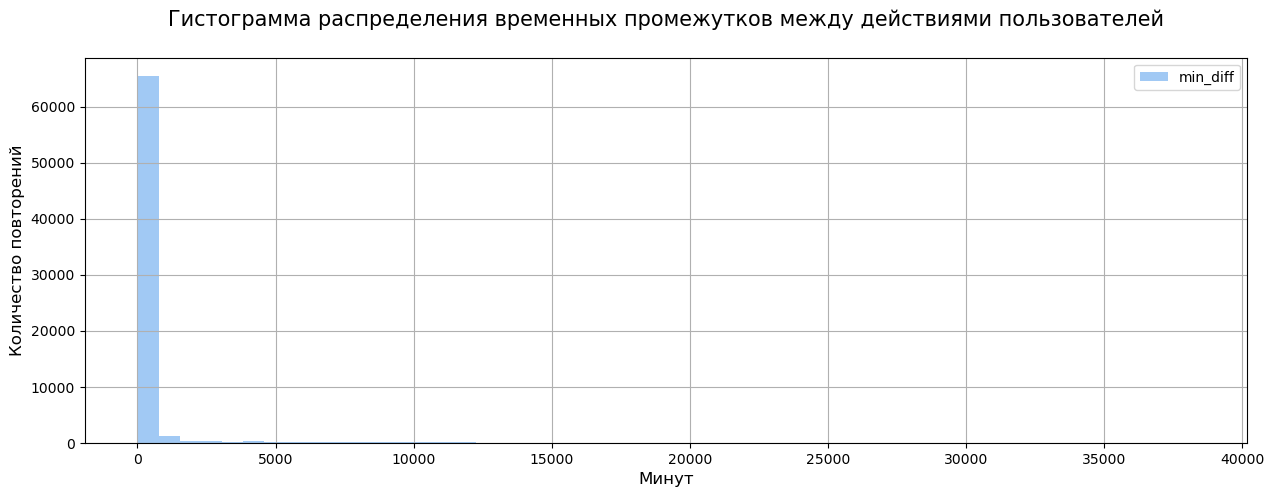

In [26]:
timeout.plot(
    kind='hist', #построим гистограмму
    legend=True,
    figsize=(15,5),
    grid=True,
    bins=50
)

#зададим наименования графика
plt.title('Гистограмма распределения временных промежутков между действиями пользователей\n', fontsize=15)

#подпишем оси графика
plt.xlabel('Минут', fontsize=12)
plt.ylabel('Количество повторений', fontsize=12);

В таком формате гистограмма не наглядна и ее сложно интерпритировать, т.к. большое скопление данных в районе 0 минут и очень длинный хвост в сторону очень больших временых разрывов между действиями. Ограничим количество минут до 50 минут, а также ограничим количество повторений до 500 и снова построим гистограмму: 

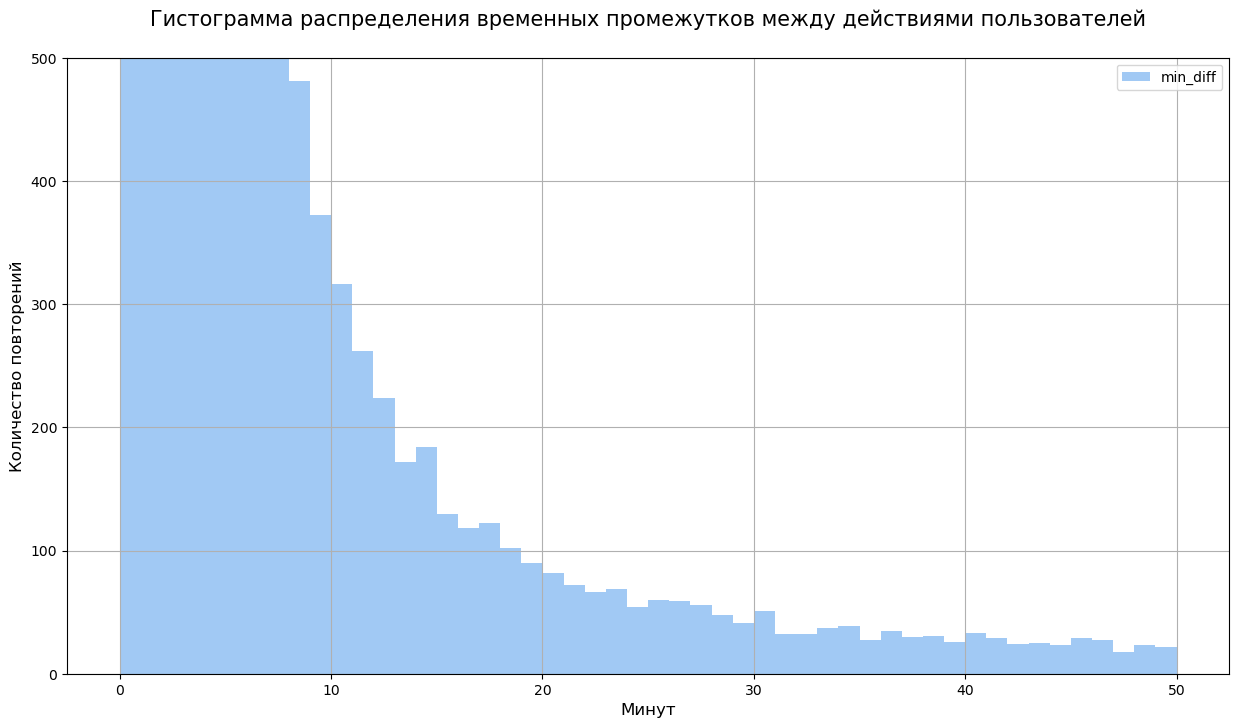

In [27]:
timeout.plot(
    kind='hist', #построим гистограмму
    legend=True,
    figsize=(15,8),
    grid=True,
    bins=50,
    range=(0,50), #изменили рассматриваемое количество минут
)
plt.ylim(0,500) #ограничили отображаемое количество повторений

#зададим наименования графика
plt.title('Гистограмма распределения временных промежутков между действиями пользователей\n', fontsize=15)

#подпишем оси графика
plt.xlabel('Минут', fontsize=12)
plt.ylabel('Количество повторений', fontsize=12);

Теперь картина стала яснее. Видно, что мелкие перерывы скопились 0 до 5 минут, дальше идет сильный спад. В районе 30 минут динамика спада уменьшается. В целом, исходя из опыта, **примем 30 минут - это оптимальное время для признания тайм-аута**.

**Переходим к выделению пользовательских сессий:**

In [28]:
#определим группы с разницей в 30 минут
groups = (
    mobile_dataset
    .groupby('user_id')['event_time'] #сгруппируем датасет по пользователям и для каждого по столбцу со времнем определим,
.diff() > pd.Timedelta('30Min')   #где логическое выражение разница между соседними строками больше 30 мин.
).cumsum()                          #и если это является истиной то для каждой такой новой группы будет прибавлена 1 (True)

#создадим дополнительный столбец session_id с уникальными номерами сессий, который будут присовены для каждого события
mobile_dataset['session_id'] = (
    mobile_dataset
    .groupby(['user_id', groups]) #сгруппируем датасет по пользователям и выделенным гуппам (сессиям)
    .ngroup() #прнумеруем полученные группы
    + 1 #и каждой группе прибавим 1, т.к. нумерация при ngroup начинается с 0
)

#для удобства задаим следующую очередность столбцов датафрейма и перезапишем индексы
mobile_dataset = mobile_dataset[['user_id', 'event_time', 'event_name', 'session_id']].reset_index(drop=True)

#выведем первые 15 строк полученного датафрейма
mobile_dataset.head(15)

,user_id,event_time,event_name,session_id
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,tips_show,1
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31,tips_show,1
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05,tips_show,1
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20,tips_show,1
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30,tips_show,1
5,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43,tips_show,1
6,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:46:31,tips_show,1
7,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:47:32,tips_show,1
8,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:49:41,tips_show,1
9,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09 18:33:55,map,2


Пользовательские сессии сформированы. Посмотрим каково их количество:

In [29]:
#посчитаем количество уникальных сессий методом nunique
mobile_dataset['session_id'].nunique()

10368

Для анализа имеем 10 368 пользовательский сессий.

#### Определение сценариев использования приложения
<a id="scenario"></a>

Выведем для каждой сессии список порядка действий пользователя:

In [30]:
df_scenario = (
    mobile_dataset
    .groupby(['session_id', 'user_id'], as_index=False)['event_name'] #сгруппируем данные по session_id 
    .agg({'event_name':'unique'}) #и найдем уникальные значения событий для каждой сессии
    .rename(columns={'event_name':'scenario'}) #переименуем столбец с наименованием события на сценарий
)

#выведем первые 5 строк, полученного датасета
df_scenario.head()

,session_id,user_id,scenario
0,1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,[tips_show]
1,2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,"[map, tips_show]"
2,3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,"[tips_show, map]"
3,4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,"[map, tips_show]"
4,5,00157779-810c-4498-9e05-a1e9e3cedf93,"[search_1, photos_show]"


Как видно события перечень уникальных событий для одной сессии представлен в виде массива. Для того, чтобы мы могли посчитать количество уникальных сценариев, нам нужно сперва преобразовать значения в столбце `event_name` в хешируемый тип данных, например кортеж:

In [31]:
#с помощью метода apply вместе с lambda-функцией преобразуем все значения строк столбца event_name в кортеж функцией tuple
df_scenario['scenario'] = df_scenario['scenario'].apply(lambda x: tuple(x))

#посмотрим сколько всего уникальных сценариев при помощи метода nunique
df_scenario['scenario'].nunique()

692

Типы данных в строках столбца со сценариями преобразовали и смогли посчитать, что всего 692 уникальных сценария за 4 недели.

Выведем топ-20 наиболее популярных сценариев при помощи графика:

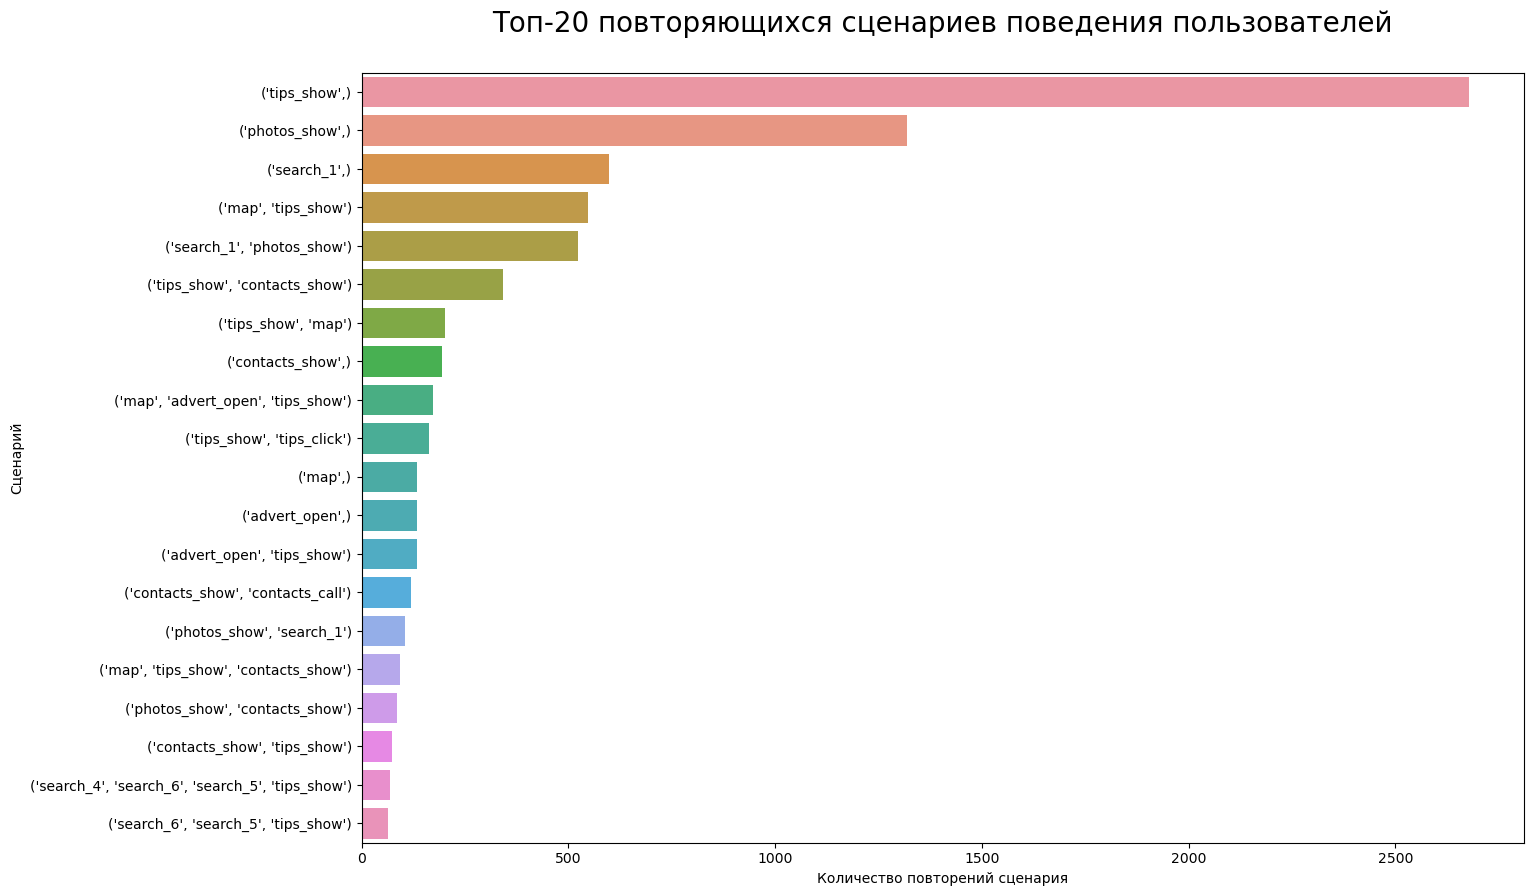

In [32]:
scenario_counts = (
    pd.DataFrame( #создадим датафрейм,
        df_scenario['scenario'].value_counts() #в котром посчитаем количество повторений уникальных сценариев
    ).reset_index() #уберем столбец со значениями сценариев из индексов
    .rename(columns={'index':'scenario', 'scenario':'count'}) #переименуем столбцы
)

#зададим размер графика
plt.figure(figsize=(15,10))

#строим столбчатую диаграмму по количеству повторений того или иного сценраия
sns.barplot(
    data=scenario_counts.head(20), #выведем первые 20 записей полученной таблицы
    x='count', #по оси х отложим количество
    y='scenario' #по оси у - сценарий
)

#задаем цветовую палитру
sns.set_palette('pastel')

#формируем заголовок графика и подписи осей средствами matplotlib
plt.title('Топ-20 повторяющихся сценариев поведения пользователей\n', fontsize=20)
plt.xlabel('Количество повторений сценария')
plt.ylabel('Сценарий');

Как видим наиболее популярным сценарием среди пользователей является `tips_show` (увидел рекомендованные объявления). Но это объяснимо, т.к. пользователь скролит ленту и видит рекомендации, и, если ему ничего не подошло, просто закрывает приложение (завершает сессию).

Следующий наиболее поппулярный сценарий - это показ фотографий `photos_show`. Значит в приложении предусмотрен функционал пролистывания фото различных объявлений без клика по самой карточке. Скорее всего, пользователь увидев заинтересовавшее его объявление пролистывает фото, чтобы принять решение двигаться ему дальше (заходить в карточку и смотреть более подробную информацию о товаре) или нет.

На 3-м месте популярным сценарием является первый поиск `search_1`: скорее всего, пользователь задает поиск, но не находит ничего подъодящего и закрывает приложение.

Посмотрим какие сценарии наименее популярны:

In [33]:
#выведем 20 наименее популярных сценариев при помощи метода tail
scenario_counts.tail(20)

,scenario,count
672,"(search_4, search_5, map, search_3, tips_show)",1
673,"(search_7, map, tips_show)",1
674,"(search_4, search_6, search_2, search_5, map, ...",1
675,"(tips_show, contacts_show, favorites_add, map,...",1
676,"(search_6, search_2, search_5, tips_show, favo...",1
677,"(search_7, search_6, search_5, tips_show, favo...",1
678,"(search_1, search_4, search_2, search_5)",1
679,"(map, search_6, search_5, tips_show)",1
680,"(favorites_add, photos_show, advert_open)",1
681,"(advert_open, tips_click)",1


Как видим наименее популярными сценариями, как правило, являются те, в которых совершенно множество различных действий пользователя.

Но нас интересуют те сценарии пользователей, которые содержат в себе целевое событие - просмотр контактов. Так мы сможем понять какая конверсия у приложения. Стоит отметить, что у приложения также имеется функция позвонить по номеру из объявления прямо из приложения, но мы не берем его за целевое событие, от которого можно было бы считать конверсию, т.к. пользователь мог остановиться на просмотре контактов, передав их кому-либо, чтобы те уже совершили звонок.

Определим сценарии, которые содержат в себе целевые действия показа контактов `contacts_show` и посчитаем их количество:

In [34]:
#определим сценарии, которые содержат целевое действие, применив lambda-функцию к столбцу event_name с условием,
#что требуется показать только те сценарии, в которых имеется значение contacts_show
contact_show = scenario_counts[scenario_counts['scenario'].apply(lambda x: 'contacts_show' in x)]

#выведем количество сценраиев, содержащих целевое действие contacts_show
contact_show.shape[0]

244

Всего 244 сценария, содержащих целевое действие, из 692 (или 35%). Выведем топ-20 самых популярных среди них при помощи диаграммы:

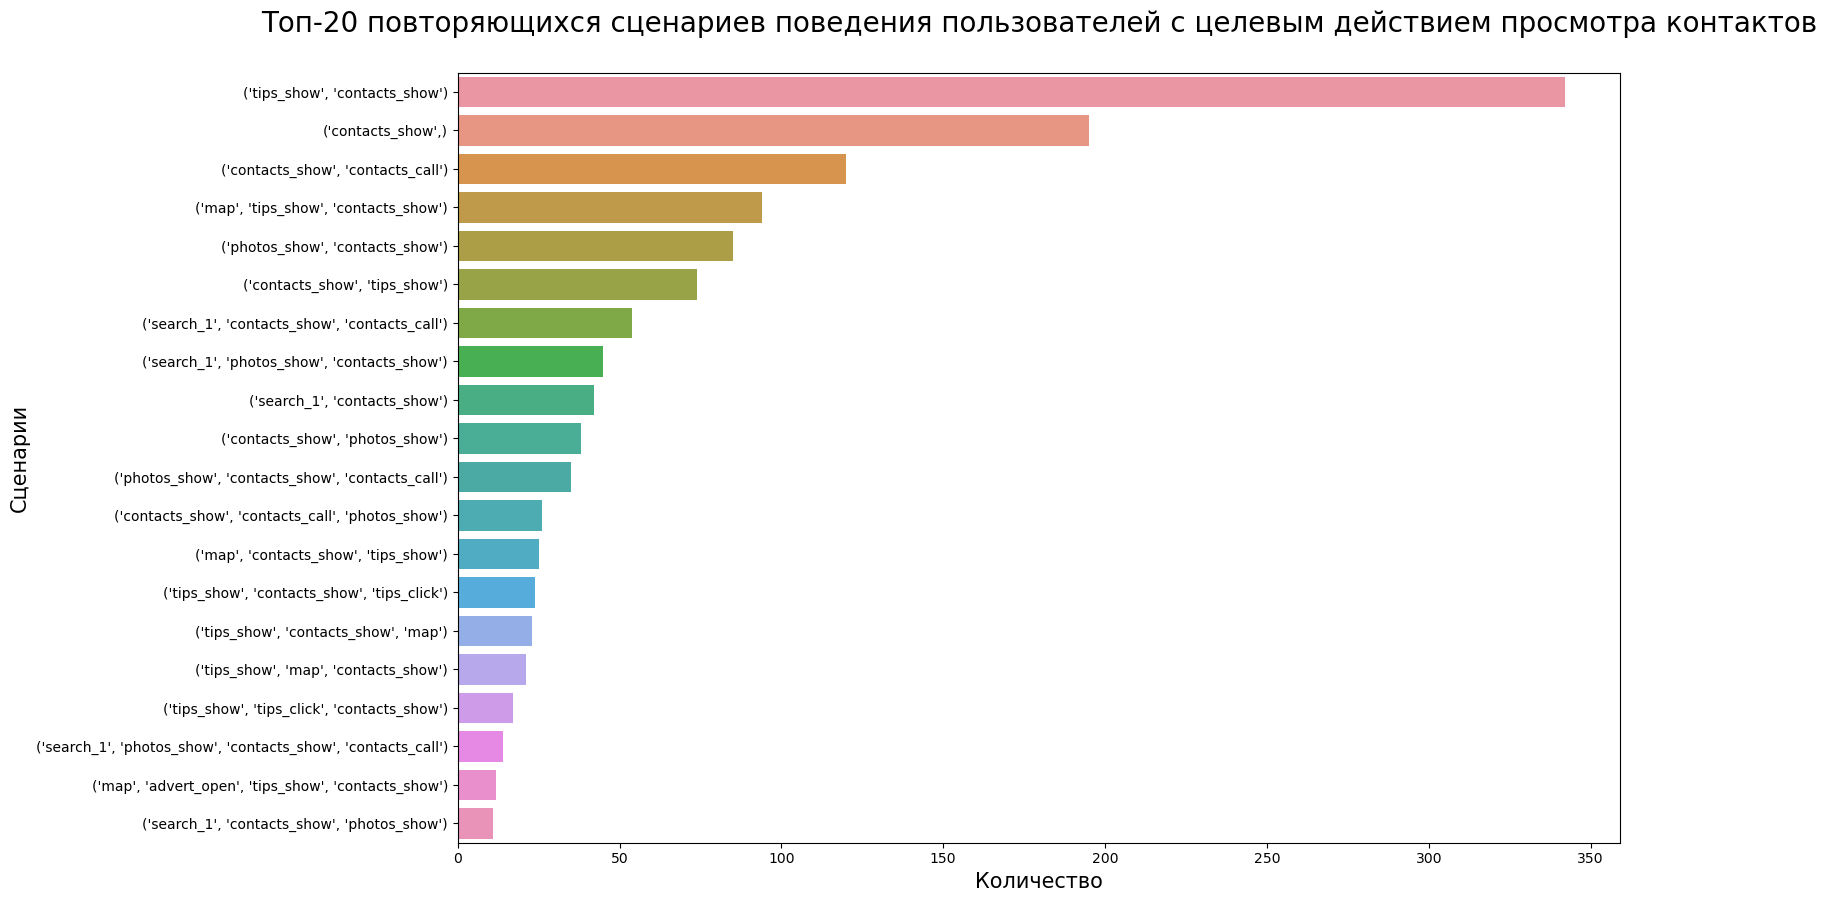

In [35]:
#зададим размер графика
plt.figure(figsize=(15,10))

#строим столбчатую диаграмму распредления по количеству повторений сценраиев, содержащих целевое действие contacts_show
sns.barplot(
    data=contact_show.head(20), #выведем первые 20 наиболее распространенных сценариев
    x='count', #по оси х отложим количество
    y='scenario' #по оси у - сценарий
)

#формируем заголовок графика и подписи осей средствами matplotlib, а также установим размер шрифтов
plt.title('Топ-20 повторяющихся сценариев поведения пользователей с целевым действием просмотра контактов\n', fontsize=20)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Сценарии', fontsize=15);

Из графика видно, что встречаются сценарии, в которых действие contacts_show является промежуточным, а не конечным. При этом видим, что популярность сценариев заметно снижается, начиная после 3-го сценария (contacts_show, contacts_call), а во 2-й раз после 6-го сценария (contacts_show, tips_show).

Посмотрим еще те сценарии, в которых целевое действие является завершающим:

92

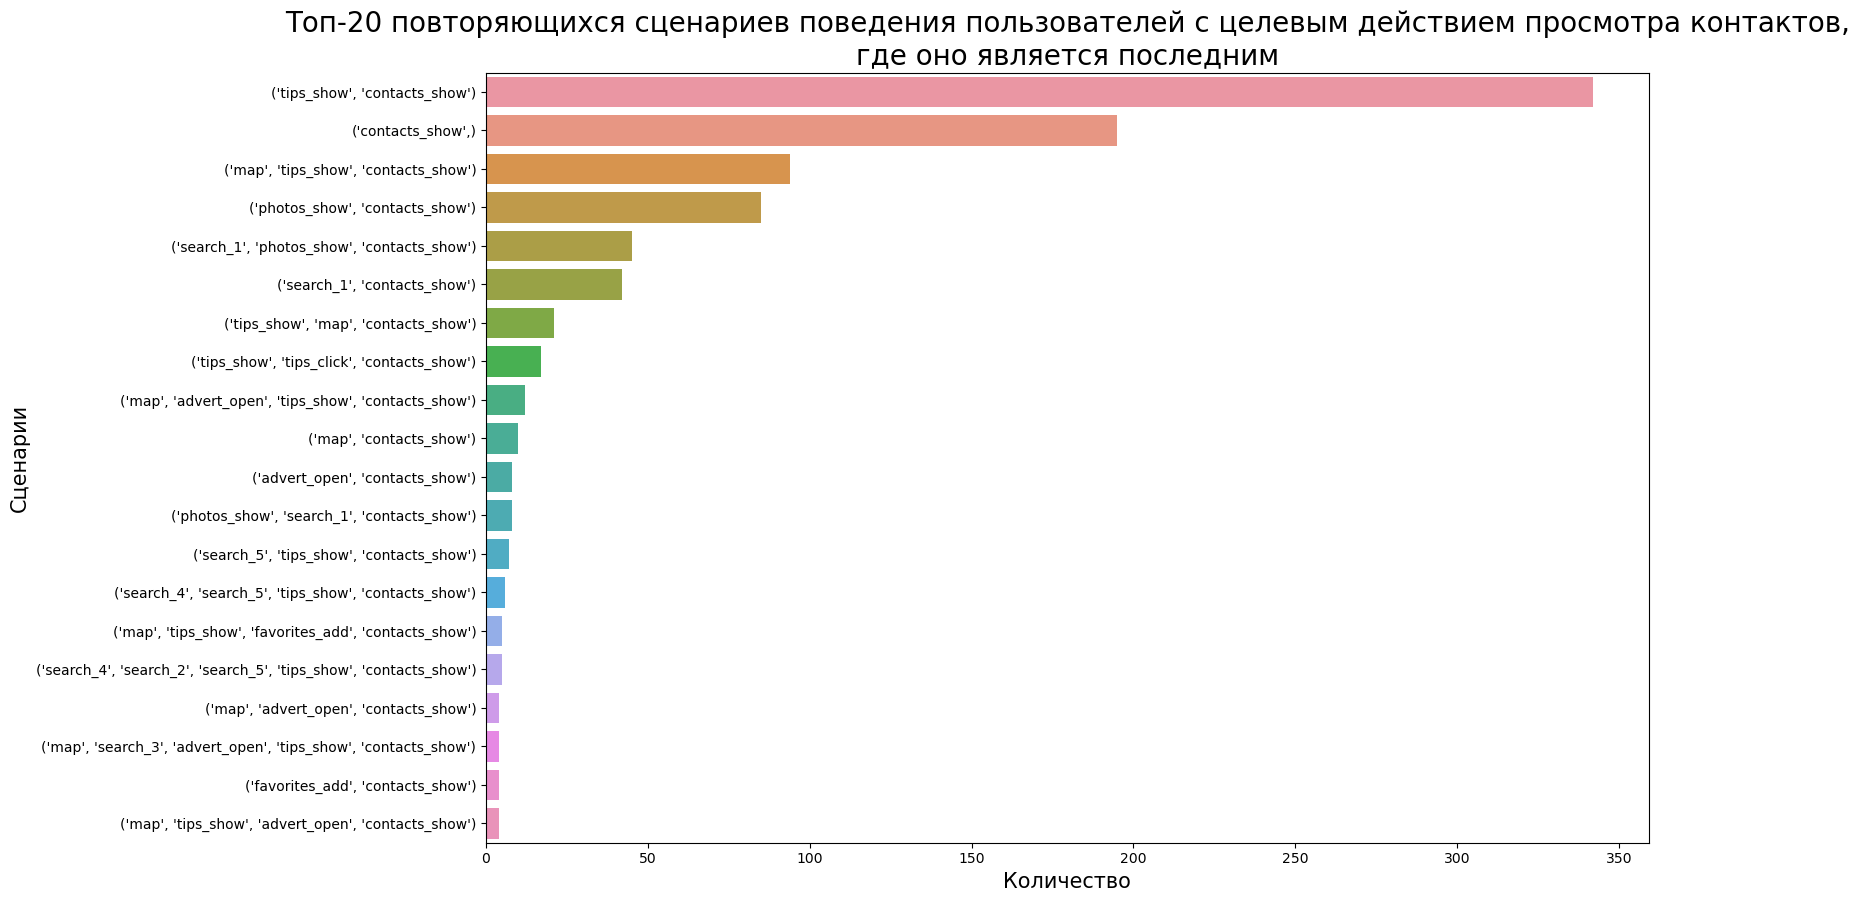

In [36]:
#определим сценарии, которые содержат целевое действие, применив lambda-функцию к столбцу event_name с условием,
#что требуется показать только те сценарии, в которых имеется значение contacts_show и оно является последним
contact_show_last = scenario_counts[scenario_counts['scenario'].apply(lambda x: x[-1] == 'contacts_show')]

#зададим размер графика
plt.figure(figsize=(15,10))

#строим столбчатую диаграмму распредления по количеству повторений сценраиев, содержащих целевое действие contacts_show
sns.barplot(
    data=contact_show_last.head(20), #выведем первые 20 наиболее распространенных сценариев
    x='count', #по оси х отложим количество
    y='scenario' #по оси у - сценарий
)

#формируем заголовок графика и подписи осей средствами matplotlib, а также установим размер шрифтов
plt.title('Топ-20 повторяющихся сценариев поведения пользователей с целевым действием просмотра контактов,\n\
где оно является последним', fontsize=20)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Сценарии', fontsize=15);

#также выведем количество сценраиев, содержащих целевое действие contacts_show, которое является последним в сценарии
contact_show_last.shape[0]

Получается сценариев, где целевое действие `contacts_show` является последним всего 92. При этом общая картина по сравнению с предыдущим графиком, где целевое действие может также являться промежуточным, сильно не изменилась, особенно если рассматривать самые популярыне сценарии. Если взять топ-5 самых популярных сценариев, где целевое действие является последним, то по сравнению с тем, где оно является промежуточным выпадает только следующий сценарий `contacts_show -> contacts_call`. Этот сценарий состоит из 2-х действий и поэтому нам он не инетерсен, т.к. в нем мы не можем определить конверсию в целевое действие, можно сказать, что для нас он равносилен как просто сценарий `contacts_show`.

Поэтому продолжим анализ по топ-5 сценариев, где присутствует целевое действие и оно является последним (соблюдена последовательность):

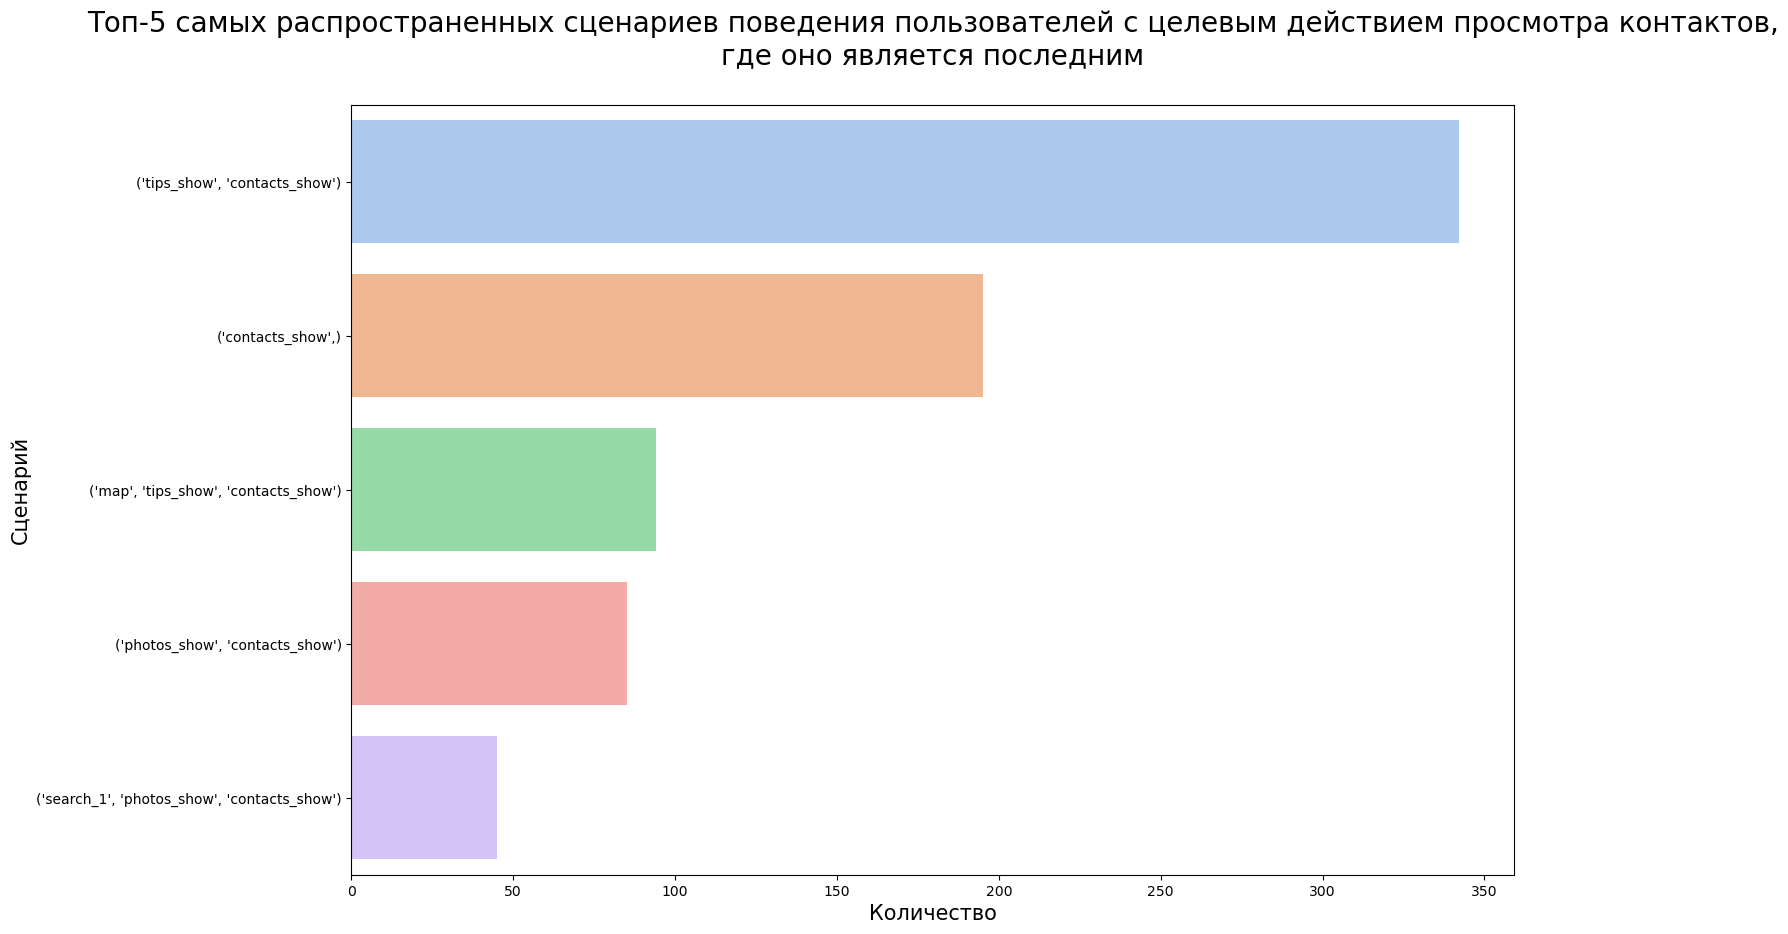

In [37]:
#зададим размер графика
plt.figure(figsize=(15,10))

#строим столбчатую диаграмму распредления по количеству повторений сценраиев, содержащих целевое действие contacts_show
sns.barplot(
    data=contact_show_last.head(5), #выведем первые 6 наиболее распространенных сценариев
    x='count', #по оси х отложим количество
    y='scenario' #по оси у - сценарий
)

#формируем заголовок графика и подписи осей средствами matplotlib, а также установим размер шрифтов
plt.title('Топ-5 самых распространенных сценариев поведения пользователей с целевым действием просмотра контактов,\n\
где оно является последним\n'
          , fontsize=20)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Сценарий', fontsize=15);

In [38]:
#дополнительно выведем таблицу с долей каждой из топ-5 самых распространенных сценариев с целевым действием просмотра контактов 
#методом div поделим каждое значение в столбце count на сумму всех повторяющихся сценариев с целевым действием
contact_show_last['part_scenario_%'] = (
    round(
        contact_show['count'].div(contact_show['count'].sum())*100
        , 1) #полученные значения округлим до 1 знака после запятой
)
    
#выведем топ-5 наиболее распространенных сценариев с целевым действием
contact_show_last.head(5).reset_index(drop=True)

,scenario,count,part_scenario_%
0,"(tips_show, contacts_show)",342,20.1
1,"(contacts_show,)",195,11.5
2,"(map, tips_show, contacts_show)",94,5.5
3,"(photos_show, contacts_show)",85,5.0
4,"(search_1, photos_show, contacts_show)",45,2.6


In [39]:
contact_show_last

,scenario,count,part_scenario_%
5,"(tips_show, contacts_show)",342,20.1
7,"(contacts_show,)",195,11.5
15,"(map, tips_show, contacts_show)",94,5.5
16,"(photos_show, contacts_show)",85,5.0
28,"(search_1, photos_show, contacts_show)",45,2.6
...,...,...,...
668,"(search_5, advert_open, tips_show, contacts_show)",1,0.1
669,"(search_2, search_5, tips_show, map, contacts_...",1,0.1
676,"(search_6, search_2, search_5, tips_show, favo...",1,0.1
686,"(search_4, map, search_3, tips_show, contacts_...",1,0.1


**Самым распростаренным сценарием**, который приводит к просмотру контактов, является (tips_show, contacts_show) - **показ рекомендованного объявления -> просмотр контактов**, его доля составляет **20%**. 
tips_show - показ рекомендованного объявления является премиальной функцией, которая дополнительно оплачивается продавцом, чтобы приложение выдавало покупателям его в качестве рекомендации.  
Получается, что вложения пользователей оправдвны и больше всего целевого события - просмотра контактов происходит именно по рекомендациям.

Cледующим наиболее распространенным сценарием с целевым событием является просто **показ контактов (11%)**, т.е. само целевое событие. Этому есть 2 возможных объяснения:
- пользователь просто листает ленту с объявлениями и сразу же нажимает на показ контактов, чтобы купить продукт;
- вторая версия - пользователь предварительно добавил товар в избранное `favorites_add`, а затем спустя больше, чем полчаса точно вернулся в приложение, зашел в избранное и уже нажал на просмотр контактов. Но точно это не представляется установить, т.к. в данном случае сложно определить через какое время после добавления в избранное пользователь возвращается к этим объявлениям и смотрит контакты.

В 3-м сценарии (**5,5%** от всех) **пользователь сперва открывает карту объявлений, видит рекомендованные объявления и переходит в просмотр контактов**. Т.е. снова рекомендации срабатывают.

Также неплохой переход в целевые действия и у 4-го сценария, где пользователь **смотрит контакты после просмотра фотографий**. Доля таких сценариев составляет **5%**.

5-м наилучишим сценарием является с первым действием **"поиск" затем "просмотр фото" и переходом в целевое событие**. Их доля составляет **2,6%**.

#### Построение воронок различных сценариев в целевое действие
<a id="funnel"></a>

Построим воронки в целевые действия по сценариям, определенным в предыдущем шаге с учетом сессий.

Для этого напишем функцию:

In [40]:
''' Данная функция принимает на вход 2 аргумента:
1. датасет, из которого будут браться данные о пользователях, уникальных сессиях и событиях, совершенных ими;
2. события сценария, который хотим рассмотреть, чтобы рассчитать для него конверсию пользователей.
При этом количество пользователей для каждого события рассчитывается в рамках ранее определенных 
уникальных пользователей в предыдущем событии.

'''

def calculate_conversion(dataset, events):
    result = [] #создаем пустой список result, который будет содержать результаты вычислений
    prev_event_users = None #задаем переменные prev_event_users и prev_event_sessions со значением None
    prev_event_sessions = None #они будут использоваться для отслеживания предыдущих данных
                                 #и использоваться при выполнении последующих шагов
        
    for i, event in enumerate(events): #запускаем цикл for, перебирающий каждое событие в списке events
                                    #с помощью функции enumerate(),
                                    #которая обеспечивает доступ к текущему индексу события (переменная i)
                                    #и к самому событию (переменная event)
        if prev_event_users is None: #если prev_event_users пустой - это означает, что это первое событие в списке
                                    #и для него находятся все уникальные пользователи, которые участвуют в этом событии 
            curr_event_users = dataset[dataset['event_name'] == event]['user_id'].unique()
        else:  #если prev_event_users уже инициализирован,
            prev_event_sessions = dataset[ #то находим сессии, в которых участвовали пользователи из предыдущего события
            (dataset['user_id'].isin(prev_event_users)) & #для этого фильтруем датасет по пользователям из предыдущего события
            (dataset['event_name'].isin(events[:i+1])) #и по событиям от начала списка events
                                                        #до рассматриваемого события включительно
        ].groupby(
                'user_id' #полученный датасет групируем по пользователям
            )[
                'session_id'
            ].unique( #выделяем список уникальных сессиий в массив данных для каждого пользователя
            ).explode() #и к полученному столбцу применяем explode, чтобы превратить каждый элемент массива 
                        #в отдельную строку датафрейма
            
            curr_event_users = dataset[ #находим пользователей текущего события
                (dataset['event_name'] == event) & #фильтруем датасет по рассматриваемому событию
                (dataset['user_id'].isin(prev_event_users)) & #по пользователям из предыдущего события
                (dataset['session_id'].isin(prev_event_sessions)) #и по сессиям из предыдущего события
            ]['user_id'].unique() #выделяем уникальных пользователей
        
        result.append({'event_name': event, 'unique_users': len(curr_event_users)}) #в результат (result) создаем словарь,
                                            #в котором будут отображены 'event_name' - наименование рассматриваемого
                                            #события из списка и 'unique_users' - количество уникальных пользователей
                                            
        prev_event_users = curr_event_users #перезаписываем переменную с предыдущими пользователями на текущих
        
    
    conversion_data = pd.DataFrame(result) #создаем датафрейм conversion_data из переменной result,
                                        #в котором далле будем рассчитывать конверсию
    
    #создаем в полученном датафрейме колонку conversion_rate, которая представляет собой отношение
    #количества уникальных пользователей к количеству уникальных пользователей первого события
    conversion_data['conversion_rate_%'] = conversion_data['unique_users'] / conversion_data['unique_users'].loc[0]
    
    #добавим столбец с конверсией в переход с предыдущего шага
    conversion_data['conv_prev_step'] = conversion_data['unique_users'] / conversion_data['unique_users'].shift(1)

    #посчитаем потерю пользователей при переходе
    conversion_data['transition_loss'] = 1 - conversion_data['conv_prev_step']
    
    #заполним пропуски прочерками
    conversion_data = conversion_data.fillna('-')
    
    
    
    #построим сразу с помощью библиотеки plotly график воронки
    fig = go.Figure(
        go.Funnel(
            y=conversion_data['event_name'], #передадим названия событий
            x=conversion_data['unique_users'], #передаем количество пользователей для каждого события
            textinfo = 'value+percent initial' #отобразим абсолютные значения и конверсию на каждом шаге
        )
    )
    
    #задаим наименование и подписи оси y, а также размер графика
    fig.update_layout(title='Воронка событий сценария {}'.format(events),
                      yaxis_title='События воронки',
                      width=800,
                      height=400)
 
    #возвращаем полученный датафрейм и график
    return conversion_data, fig.show('png')

Функция написана.

Теперь **посчитаем конверсию по наиболее популярному сценарию в целевое действие -  показ рекомендованного объявления -> просмотр контактов** (tips_show, contacts_show) и построим график воронки:

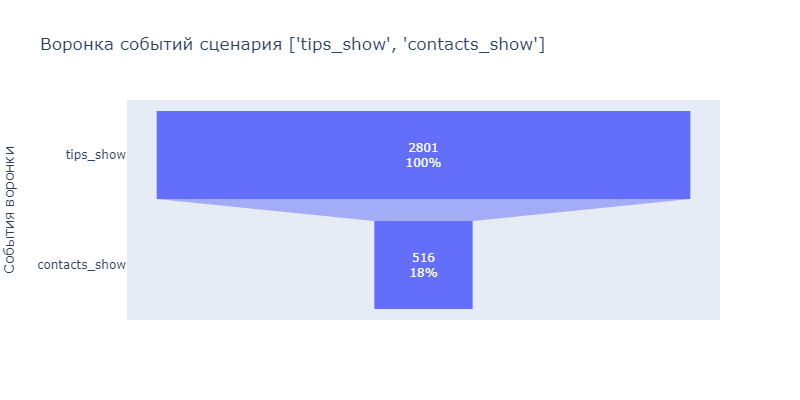

,event_name,unique_users,conversion_rate_%,conv_prev_step,transition_loss
0,tips_show,2801,1.00000,-,-
1,contacts_show,516,0.18422,0.18422,0.81578


In [41]:
#вызываем функцию calculate_conversion передав ему в датафрейм mobile_dataset
#и события из рассматриваемого сценария tips_show, contacts_show
tips_show_contacts_show, fig = calculate_conversion(mobile_dataset, ['tips_show', 'contacts_show'])

#выведем полученные результаты
tips_show_contacts_show

Конверсия в целевое действие при таком сценарии равна 18%.

Сделаем то же самое для **сценария карта -> пользователь увидел рекомендованное объявление -> просмотр контакта** (map, tips_show, contacts_show):

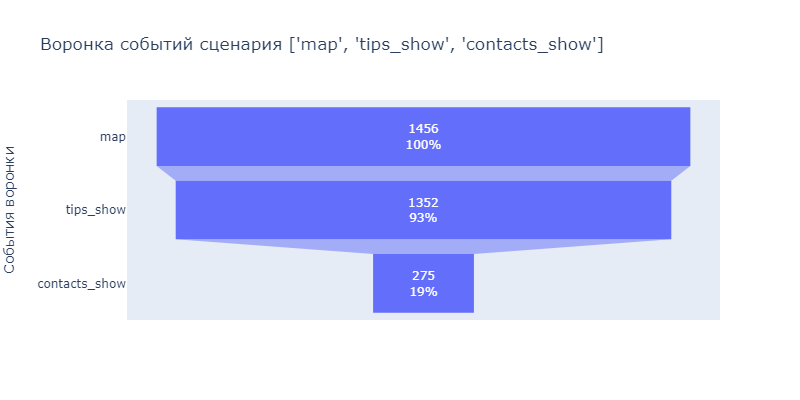

,event_name,unique_users,conversion_rate_%,conv_prev_step,transition_loss
0,map,1456,1.000000,-,-
1,tips_show,1352,0.928571,0.928571,0.071429
2,contacts_show,275,0.188874,0.203402,0.796598


In [42]:
#вызываем функцию calculate_conversion передав ему в датафрейм mobile_dataset
#и события из рассматриваемого сценария map, tips_show, contacts_show
map_tips_show_contacts_show, fig = calculate_conversion(mobile_dataset, ['map', 'tips_show', 'contacts_show'])

#выведем полученные результаты
map_tips_show_contacts_show

У данного сценраия коверсия в целевое действие немного выше на 0,5%.

Рассмотрим воронку для 4-го сценария из топ-5 - **просмотр фото -> просмотр контакта** (photos_show, contacts_show):

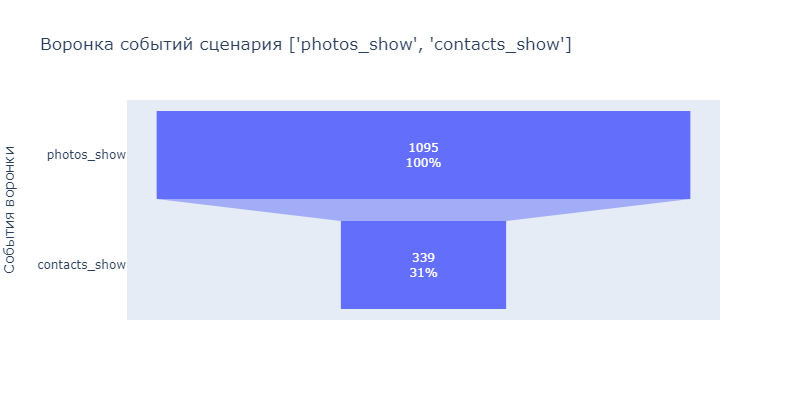

,event_name,unique_users,conversion_rate_%,conv_prev_step,transition_loss
0,photos_show,1095,1.000000,-,-
1,contacts_show,339,0.309589,0.309589,0.690411


In [43]:
#вызываем функцию calculate_conversion передав ему в датафрейм mobile_dataset
#и события из рассматриваемого сценария photos_show, contacts_show
photos_show_contacts_show, fig = calculate_conversion(mobile_dataset, ['photos_show', 'contacts_show'])

#выведем полученные результаты
photos_show_contacts_show

Пока это самая высокая конверсия в пользователи у данного сценария: люди смотрят фото - загораются продуктом, и смотрят контакты, чтобы договориться о покупке.

Посчитаем воронку для последнего из рассматриваемых сценариев `search_1 -> photos_show -> contacts_show` (**поиск -> просмотр фото -> просмотр контактов**):

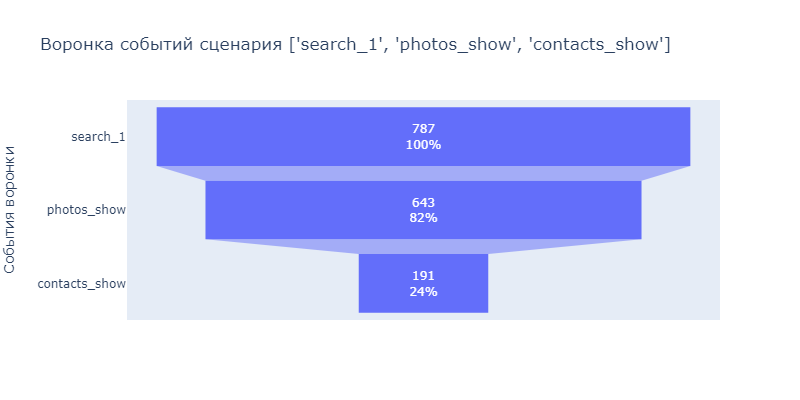

,event_name,unique_users,conversion_rate_%,conv_prev_step,transition_loss
0,search_1,787,1.000000,-,-
1,photos_show,643,0.817027,0.817027,0.182973
2,contacts_show,191,0.242694,0.297045,0.702955


In [44]:
#вызываем функцию calculate_conversion передав ему в датафрейм mobile_dataset
#и события из рассматриваемого сценария search_1, photos_show, contacts_show
search1_photos_show_contacts_show, fig = calculate_conversion(mobile_dataset, ['search_1', 'photos_show', 'contacts_show'])

#выведем полученные результаты
search1_photos_show_contacts_show

Тут тоже хорошая конвесрия - 24%, но все же ниже, чем после простого просмотра фото.

Есть вероятность, что пердыдущий сценарий из просмотра фото в просмотр контактов формируется за счет объявлений, которые раньше были добавлены в избранное и пользователь просто решил вернуться к тому, что когда-то отобрал. Таким образом конверсия будет выше, чем когда пользователь все делает в рамках одной сессии: и поиск, и просмотр фото, и уже после всего этого идет в просмотр контактов. Ведь при втором раскладе очень много объявлений может отпасть, в то время как в первом варианте эти объявления уже прошли проверку.

Есть и другая вероятность, что поиск в приложении работает неочень корректно, от этого и пользователей неочень интересуют полученные результаты в отобранных объявлениях. Ведь, если вспомнить самое начало, у нас очень много сценариев,. где пользователй совершает только поиск и выходит из сессии, так и не сделав больше никаких действий, т.е. не найдя ничего подоходящего.

**Вывод:** Получается среди топ-5 наиболее распространенных сценариев в целевое действие - 4 пригодны для анализа конверсии. Из этих 4-х сценариев самый успешный по конверсии в пользователи - `просмотр фото -> просмотр контакта` (31%), следующий сценарий по уровню конверсии `поиск -> просмотр фото -> просмотр контактов` (24%), а следом за ним 2 сценария (`карта -> пользователь увидел рекомендованное объявление -> просмотр контакта` (18,9%) и `показ рекомендованного объявления -> просмотр контактов` 18,4%) близки к друг другу по размеру конверсии (отличие на 0,5%).

Все таки конверсия при помощи рекламы выше, когда пользователь предварительно смотрит карту с объявлениями, а на ней уже видит рекомендованные объявления.

Самая высокая конверсия у пользователей, совершающих действие просмотр фотографий перед тем как перейти в контакты. Можно было бы сделать какой-то апргрейд, чтобы пользователь кликнув на карте по рекомендованному объявлению смог выбрать предварительную опцию (до перехода в карточку) по просмотру фото в виде скролла.

И еще стоит проверить корректно ли работает поиск, т.к. конверсия при целевом поиске и просмотре фотографий ниже, чем просто после просмотра фотографий. А может быть, конверсия после просто просмотра фото выше потому, что эти просмотры пришли из объявлений, отобранных в избранное в рамках других сесиий.

#### Проанализируем как отличается время между событиями `advert_open`->`contacts_show` и `tips_click`->`contacts_show`
<a id="event_time"></a>

Напишем функцию на расчет разницы во времени между двумя событиями:

In [45]:
'''
Эта функция принимает на вход 2 аргумента:
1. датасет с данными, откуда можно взять время осбытия, его наименование и уникальное значение сессии;
2. событие, от которого хотим найти расстояние во времени до целевого contacts_show.
Она рассчитывает разницу между двумя ближайшими указанными событиями и вовзращает датафрейм разницей во времени и 
session_id, в котором произошли эти 2 события.
'''

#создадим функцию, которая принимает на вход 2 аргумента - датасет и проверяемое событие
def time_diffrence(data, event):
    filtred_data = data[data['event_name'].isin([event, 'contacts_show'])] #фильтруем датасет по исследуемым событиям 
    grouped = filtred_data.groupby('session_id') #создаем новую переменную, в которой будет сгруппирован отфильтрованный датасет
                                                #по session_id
    #создаем переменную, в которой к сгруппированному и отфильтрованному датасету grouped применям лямбда-функцию, в которой
    result = grouped.apply(lambda x:
                           (x[x['event_name'] == 'contacts_show']['event_time'].iloc[0] - #фильтруем по событию contacts_show
                            #и возвращаем соответствующее ему первое встречающееся значение времени
                            x[x['event_name'] == event]['event_time'].iloc[0]) #аналогично делаем для события, заданного
                                                                               #в аргументе функции
                           if #делаем проверку на присутствие обоих событий в сессии
                           (x['event_name'] == 'contacts_show').any() #если в группе есть события contacts_show и event,
                           and 
                           (x['event_name'] == event).any()
                           else pd.NaT) #то возвращает вычисленную разницу времени, иначе возвращает pd.NaT (Not a Time)

    #из полученной таблицы формируем датафрейм
    result_df = pd.DataFrame(result, columns=['duration'])
    
    #выполняем проверку: если вдруг целевое значение было осуществлено до того, как было выполнено предыдущее, то
    #такие значения не войдут в сформированные данные (они будут отрицательными),
    #кроме того убираем из данных строки с упстыми значениями

    result_df = result_df[result_df['duration'].notnull() & (result_df['duration'] >= pd.Timedelta(0))].reset_index()
    result_df['duration'] = round(result_df['duration'].dt.total_seconds() / 60, 2)
    
    #возвращаем полученный датафрейм
    return result_df

Функция написана, теперь применем ее для исследуемых пар событий `advert_open`->`contacts_show` и `tips_click`->`contacts_show`:

In [46]:
#применим полученную функцию для advert_open и contacts_show и рассчитаем разницу между событиями для каждой сессии
diff_adv_open = time_diffrence(mobile_dataset, 'advert_open')

#аналогично сделаем для пары событий tips_click contacts_show
diff_tips_click = time_diffrence(mobile_dataset, 'tips_click')

#выведем описание полученных таблиц
display(
    'Описание полученной разницой во времени между событиями `advert_open`->`contacts_show`',
    diff_adv_open['duration'].describe(),
    'Описание полученной разницой во времени между событиями `tips_click`->`contacts_show`',
    diff_tips_click['duration'].describe()
)

'Описание полученной разницой во времени между событиями `advert_open`->`contacts_show`'

count    97.000000
mean      8.027732
std      12.358800
min       0.050000
25%       1.020000
50%       2.970000
75%       9.850000
max      70.850000
Name: duration, dtype: float64

'Описание полученной разницой во времени между событиями `tips_click`->`contacts_show`'

count    28.000000
mean     13.591429
std      13.478651
min       0.280000
25%       3.920000
50%       7.845000
75%      19.905000
max      50.800000
Name: duration, dtype: float64

Из полученного описания видим, что сессий с переходом из `advert_open` в `contacts_show` за исследуемый период совершено пользователями больше, чем из `tips_click` в `contacts_show`'. При этом среднее время перехода из `advert_open` в целевое событие меньше, чем время перехода из `tips_click` (почти 3 минуты против почти 8 минут).

**Значит пользватели активнее переходят в контакты, когда заходят в собственный поиск товара, а по рекомендованным объявлениям они осущевляют данный переход почти в 2,5 раза дольше.**

Построим также гистограмму распредления разницы во времени между рассматриваемыми событиями:

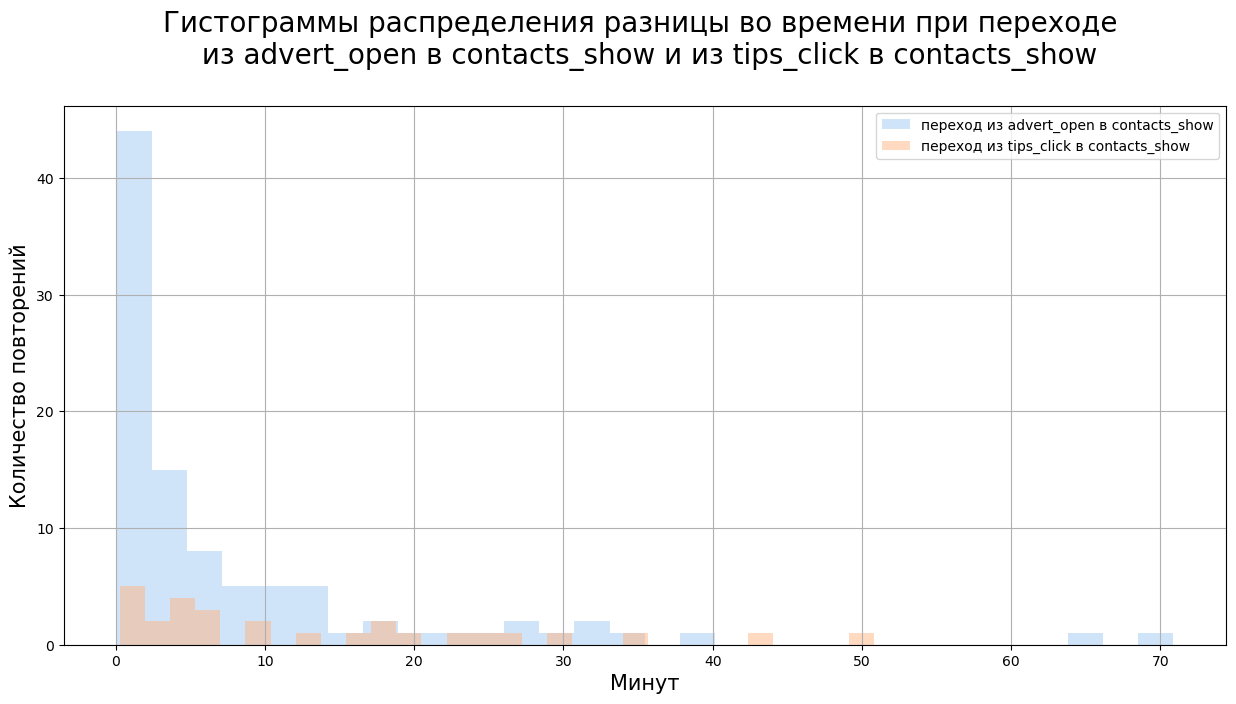

In [47]:
#зададим размер графика
plt.figure(figsize=(15,7))

#строим первую гистограмму распределения разницы во времени при переходе из advert_open в contacts_show
plt.hist(diff_adv_open['duration'], alpha=0.5, label='переход из advert_open в contacts_show', bins=30)

#строим первую гистограмму распределения разницы во времени при переходе из tips_click в contacts_show
plt.hist(diff_tips_click['duration'], alpha=0.5, label='переход из tips_click в contacts_show', bins=30)

#отобразим легенду
plt.legend(loc='upper right')
#отобразим сетку
plt.grid()

plt.title('Гистограммы распределения разницы во времени при переходе \n из advert_open в contacts_show\
 и из tips_click в contacts_show\n', fontsize=20)
plt.xlabel('Минут', fontsize=15)
plt.ylabel('Количество повторений', fontsize=15);

Помимо ранее сделанных выводов, из графика видно, что иногда разрыв между кликом покарточке объявления до просмотра контактов может достигать и 60 и 70 минут, но это редкие значения, возможно было пару таких усидчивых в поиске пользоваетелей.

Аналогичная ситуация по расстоянию во времени между клику по рекомендованному объявлению и по переходу в просмотр контактов, но тут уже гораздо меньше такие большие разрывы - около 45-50 минут.

#### Определим какая конверсия у событий advert_open и tips_click в целевое действие - contacts_show
<a id="conversion"></a>

Для этого применим ранее написанную функцию calculate_conversion. Сперва посчитаем конверсию для пары событий advert_open и contacts_show:

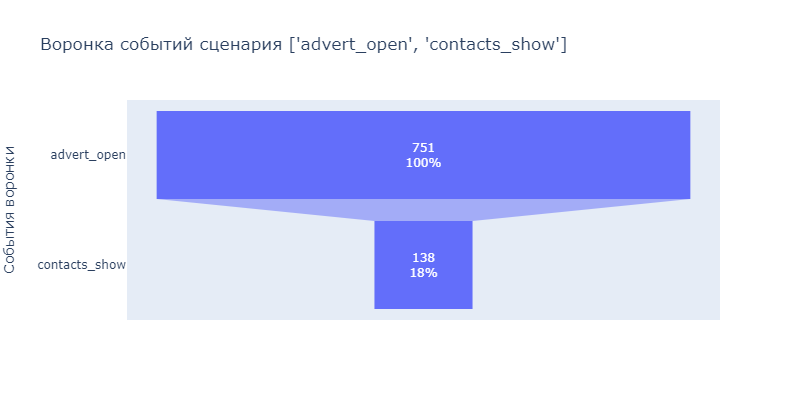

,event_name,unique_users,conversion_rate_%,conv_prev_step,transition_loss
0,advert_open,751,1.000000,-,-
1,contacts_show,138,0.183755,0.183755,0.816245


In [48]:
#применим функцию calculate_conversion, передав ей аргуметы mobile_dataset и список рассматриваемых событий
advert_open_contacts_show, fig = calculate_conversion(mobile_dataset, ['advert_open', 'contacts_show'])

#выведем полученные результаты
advert_open_contacts_show

Конверсия в целевое событие из действия пользователя "открыл карточку объявления" составляет 18%.

Аналогично сделаем расчет конверсии из tips_click в целевое действие:

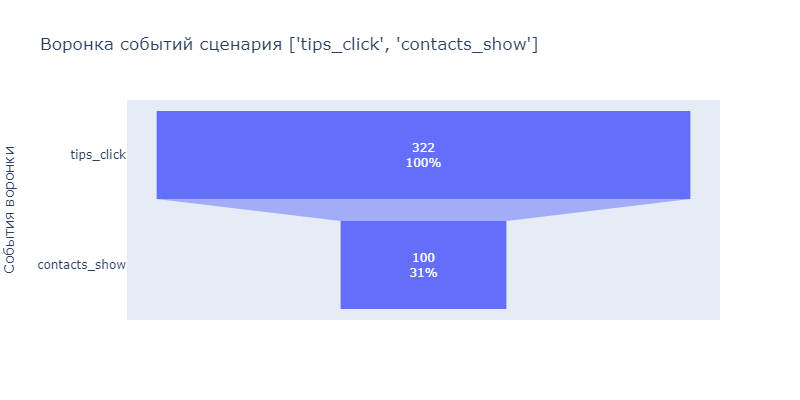

,event_name,unique_users,conversion_rate_%,conv_prev_step,transition_loss
0,tips_click,322,1.000000,-,-
1,contacts_show,100,0.310559,0.310559,0.689441


In [49]:
#применим функцию calculate_conversion, передав ей аргуметы mobile_dataset и список рассматриваемых событий
tips_click_contacts_show, fig = calculate_conversion(mobile_dataset, ['tips_click', 'contacts_show'])

#выведем полученные результаты
tips_click_contacts_show

Конверсия в целевое действие после "клика по рекомендованному объявлению" выше, чем по поисковому, и составляет 31%.

**Таким образом не смотря на то, что время по переходу в целевое событие из клика по поисковому объявлению меньше, чем из клика по рекомендованному объявлению почти на 5 минут, конверсия в целевое действие во втором случае выше почти на 13%. Т.е. все таки рекомендации работают, просто вполне возможно, что пользователи сомневаются. Возможно, если заказчику необходимо уменьшить разрыв во времени между кликом по рекомендованному объявлению и переходом в целевое действие, то можно внедрить ранее предложенную рекомендацию при расчете воронок сценариев в целевое действие - это добавления в предпросмотре рекомендованных объявлений фотографий, которые можно скролить.**

#### Определим удовлетворенность пользователей приложением, посчитав их удержание - `Retention rate`
<a id="retention"></a>

Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются с компанией. Это один из важнейших показателей «здоровья» бизнеса.

Чтобы узнать Retention Rate, нужно разделить количество активных пользователей на текущий день на количество активных пользователей на первый день.

Приступим:

In [50]:
#скопируем исходный датафрейм mobile_dataset в новую переменную для вычисления удержания
df_for_retention = mobile_dataset.copy()

#добавим столбец с первым событием для каждого пользователя
df_for_retention['first_ts'] = df_for_retention.groupby('user_id')['event_time'].transform('min')

#добавим столбец с началом каждой сессии
df_for_retention['session_start'] = df_for_retention.groupby('session_id')['event_time'].transform('min')

#сгруппируем датафрейм по сессиям и выведем первую строку для каждой
df_for_retention = df_for_retention.groupby('session_id', as_index=False).first()

#рассчитаем лайфтайм для каждой сессии в днях
df_for_retention['lifetime'] = (df_for_retention['session_start'] - df_for_retention['first_ts']).dt.days

#добавим столбец с датой, когда пользователь впервые посетил приложение
df_for_retention['event_dt'] = pd.to_datetime(df_for_retention['first_ts']).dt.date

#оставим все столбцы датафрейма кроме event_time - он нам больше не потребуется
df_for_retention = df_for_retention.drop('event_time', axis=1)

#выведем первые 5 строк полученного датасета
df_for_retention.head()

,session_id,user_id,event_name,first_ts,session_start,lifetime,event_dt
0,1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07 13:39:45,2019-10-07 13:39:45,0,2019-10-07
1,2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-07 13:39:45,2019-10-09 18:33:55,2,2019-10-07
2,3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07 13:39:45,2019-10-21 19:52:30,14,2019-10-07
3,4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-07 13:39:45,2019-10-22 11:18:14,14,2019-10-07
4,5,00157779-810c-4498-9e05-a1e9e3cedf93,search_1,2019-10-19 21:34:33,2019-10-19 21:34:33,0,2019-10-19


Определим горизонт анализа - максимальный лайфтайм, который хотим включить в анализ. Для нашего исследования посмотрим удержание на 14 день (за 2 недели использования):

In [51]:
# задаём момент и горизонт анализа данных
observation_date = df_for_retention['event_dt'].max()
horizon_days = 14

# создаём опцию «игнорировать горизонт»
ignore_horizon = False

# рассчитываем максимально возможную дату привлечения
last_suitable_acquisition_date = observation_date
if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)

# исключаем пользователей, пришедших после максимальной даты привлечения
df_for_retention = df_for_retention.query('event_dt <= @last_suitable_acquisition_date')

#строим таблицу удержания
df_for_retention_grouped = df_for_retention.pivot_table(
    index='event_dt',
    columns='lifetime',
    values='user_id',
    aggfunc='nunique'
)

df_for_retention_grouped

lifetime,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
event_dt,,,,,,,,,,,,,,,,,,,,,
2019-10-07,204.0,24.0,19.0,22.0,11.0,7.0,12.0,16.0,11.0,10.0,...,3.0,9.0,4.0,3.0,4.0,7.0,7.0,8.0,9.0,6.0
2019-10-08,167.0,27.0,21.0,9.0,7.0,11.0,9.0,12.0,9.0,6.0,...,5.0,3.0,7.0,5.0,3.0,4.0,7.0,4.0,4.0,2.0
2019-10-09,176.0,13.0,11.0,10.0,12.0,12.0,10.0,13.0,10.0,6.0,...,3.0,2.0,5.0,2.0,6.0,2.0,1.0,4.0,3.0,NaN
2019-10-10,174.0,15.0,18.0,14.0,16.0,14.0,12.0,9.0,14.0,6.0,...,10.0,6.0,5.0,3.0,7.0,3.0,2.0,2.0,NaN,NaN
2019-10-11,136.0,12.0,16.0,13.0,12.0,10.0,9.0,6.0,2.0,6.0,...,8.0,4.0,3.0,3.0,4.0,4.0,2.0,NaN,NaN,NaN
2019-10-12,125.0,15.0,20.0,7.0,8.0,11.0,10.0,11.0,10.0,8.0,...,5.0,5.0,3.0,3.0,8.0,4.0,NaN,NaN,NaN,NaN
2019-10-13,148.0,19.0,10.0,8.0,10.0,8.0,8.0,7.0,7.0,7.0,...,2.0,3.0,2.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
2019-10-14,185.0,21.0,19.0,19.0,15.0,13.0,9.0,8.0,14.0,7.0,...,7.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,186.0,25.0,16.0,14.0,10.0,10.0,15.0,14.0,12.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Следующим шагом вычислим размеры когорт:

In [52]:
#вычислим размеры когорт, сгруппировав данные по дате первого посещения из event_dt и посчитаем количество
#уникальных пользователей в каждой когорте, применив функцию nunique к столбцу user_id
cohort_sizes = (
    df_for_retention.groupby('event_dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'}) #переименуем cтолбец с результатами 
)

cohort_sizes

,cohort_size
event_dt,
2019-10-07,204
2019-10-08,167
2019-10-09,176
2019-10-10,174
2019-10-11,136
2019-10-12,125
2019-10-13,148
2019-10-14,185
2019-10-15,186


Объединим таблицу размеров когорт с таблицей удержания:

In [53]:
#объединяем размеры когорт и таблицу удержания по столбцу event_dt методом merge
#отсутствующие значения NaN заменим на 0 методом fillna()
df_for_retention_grouped = cohort_sizes.merge(
    df_for_retention_grouped, on='event_dt', how='left'
).fillna(0)

df_for_retention_grouped

,cohort_size,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
event_dt,,,,,,,,,,,,,,,,,,,,,
2019-10-07,204,204.0,24.0,19.0,22.0,11.0,7.0,12.0,16.0,11.0,...,3.0,9.0,4.0,3.0,4.0,7.0,7.0,8.0,9.0,6.0
2019-10-08,167,167.0,27.0,21.0,9.0,7.0,11.0,9.0,12.0,9.0,...,5.0,3.0,7.0,5.0,3.0,4.0,7.0,4.0,4.0,2.0
2019-10-09,176,176.0,13.0,11.0,10.0,12.0,12.0,10.0,13.0,10.0,...,3.0,2.0,5.0,2.0,6.0,2.0,1.0,4.0,3.0,0.0
2019-10-10,174,174.0,15.0,18.0,14.0,16.0,14.0,12.0,9.0,14.0,...,10.0,6.0,5.0,3.0,7.0,3.0,2.0,2.0,0.0,0.0
2019-10-11,136,136.0,12.0,16.0,13.0,12.0,10.0,9.0,6.0,2.0,...,8.0,4.0,3.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0
2019-10-12,125,125.0,15.0,20.0,7.0,8.0,11.0,10.0,11.0,10.0,...,5.0,5.0,3.0,3.0,8.0,4.0,0.0,0.0,0.0,0.0
2019-10-13,148,148.0,19.0,10.0,8.0,10.0,8.0,8.0,7.0,7.0,...,2.0,3.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,185,185.0,21.0,19.0,19.0,15.0,13.0,9.0,8.0,14.0,...,7.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,186,186.0,25.0,16.0,14.0,10.0,10.0,15.0,14.0,12.0,...,5.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Рассчитаем коэффициенты удержания:

In [54]:
#разделим данные таблицы удержания на размеры когорт. Для этого вызовем функцию div,
#передав ей столбец cohort_size в качестве делителя и параметр axis=0.
df_for_retention_grouped = df_for_retention_grouped.div(
    df_for_retention_grouped['cohort_size'], axis=0
)

#исключаем из результата все лайфтаймы, превышающие горизонт анализа
df_for_retention_grouped = df_for_retention_grouped[['cohort_size'] + list(range(horizon_days))]

#во время деления все значения cohort_size превратились в единицу
#восстанавливаем — они понадобятся нам позже
df_for_retention_grouped['cohort_size'] = cohort_sizes

df_for_retention_grouped

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
event_dt,,,,,,,,,,,,,,,
2019-10-07,204,1.0,0.117647,0.093137,0.107843,0.053922,0.034314,0.058824,0.078431,0.053922,0.049020,0.049020,0.034314,0.024510,0.058824
2019-10-08,167,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892,0.071856,0.053892,0.035928,0.059880,0.023952,0.029940,0.029940
2019-10-09,176,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818,0.073864,0.056818,0.034091,0.022727,0.028409,0.034091,0.056818
2019-10-10,174,1.0,0.086207,0.103448,0.080460,0.091954,0.080460,0.068966,0.051724,0.080460,0.034483,0.034483,0.051724,0.045977,0.040230
2019-10-11,136,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.066176,0.044118,0.014706,0.044118,0.036765,0.036765,0.051471,0.029412
2019-10-12,125,1.0,0.120000,0.160000,0.056000,0.064000,0.088000,0.080000,0.088000,0.080000,0.064000,0.064000,0.040000,0.072000,0.048000
2019-10-13,148,1.0,0.128378,0.067568,0.054054,0.067568,0.054054,0.054054,0.047297,0.047297,0.047297,0.040541,0.040541,0.047297,0.047297
2019-10-14,185,1.0,0.113514,0.102703,0.102703,0.081081,0.070270,0.048649,0.043243,0.075676,0.037838,0.037838,0.048649,0.016216,0.059459
2019-10-15,186,1.0,0.134409,0.086022,0.075269,0.053763,0.053763,0.080645,0.075269,0.064516,0.021505,0.037634,0.037634,0.032258,0.037634


Retention Rate пользователей, пришедших с 7 октября 2019 г. по 20 октября 2019 г. за первые 14 дней существоваания, посчитан.

Для наглядности и интерпритации полученных результатов построим хитмэп:

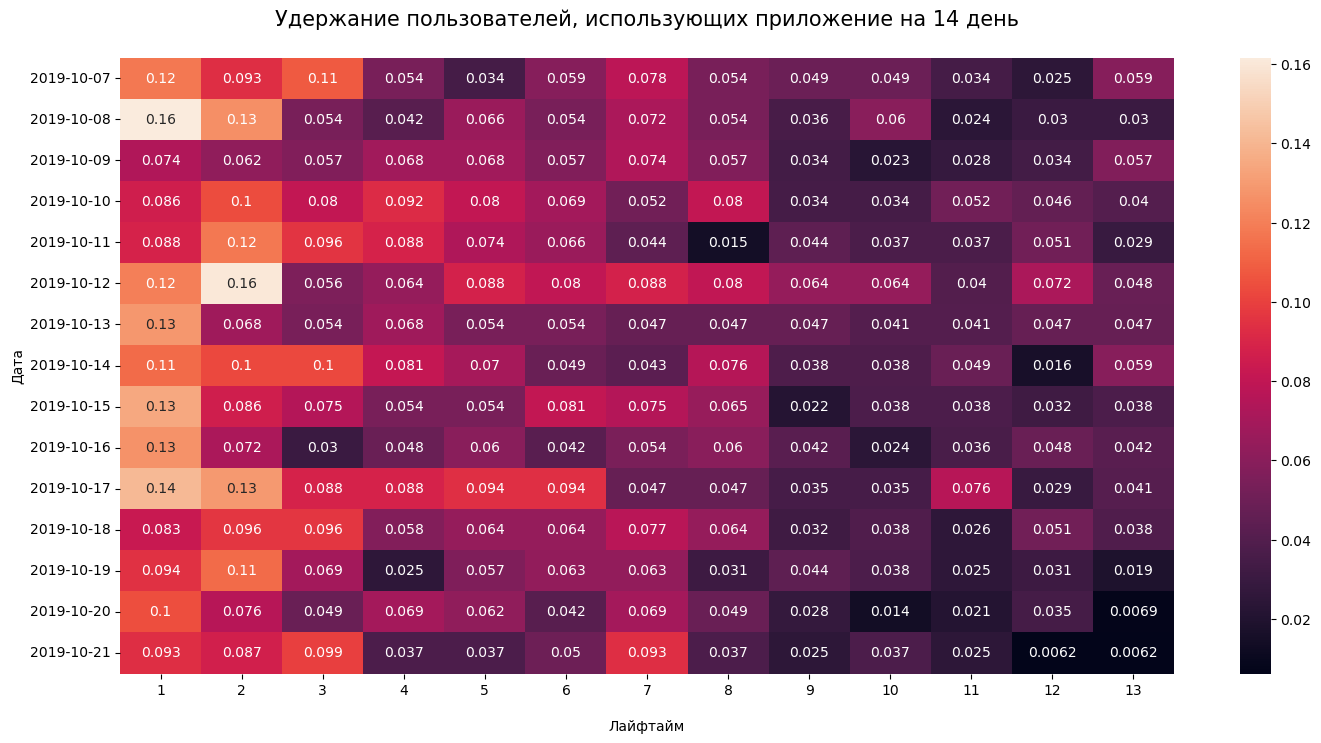

In [55]:
#задаем размер графика
plt.figure(figsize=(17, 8))

#строим хитмэп по данным остальных заведений
sns.heatmap(
    df_for_retention_grouped.drop(['cohort_size', 0], axis=1),
    annot=True
) 
#зададим наименования заголовка и подписи осей графика, а также размер шрифта
plt.title('Удержание пользователей, использующих приложение на 14 день\n', fontsize=15)
plt.xlabel('\nЛайфтайм', fontsize=10)
plt.ylabel('Дата', fontsize=10);

В целом картина удержания пользователей на 14 день неплохая, порой достигает даже 6% (когорты от 07.10.2019 и от 14.10.2019). Хуже всего себя проявили когорты от 20.10.2019 и 21.10.2019, ретеншен на 14 день не составил и 1%.  
Активный спад ретеншена происходит, начиная с 9 дня лайфтайма.

Но учитывая саму специфику приложения (купля-продажа товара) лучше рассматривать ретеншен за более долгий период - за год, а когорты формировать за месяц. Так мы больше сможе понять лояльны пользователи или нет.

### Проверка статистических гипотез
<a id="hypotheses"></a>

#### Проверка гипотезы "Конверсия в просмотры контактов различается у пользователей совершающих действия `tips_show` и `tips_click` с пользователями, совершающих только `tips_show`"
<a id="conversion_tips"></a>

Сперва посмотрим чему вообще равна конверсия в целевое действие у пользователей, совершающих `tips_show` и `tips_click` и у пользователей совершающих только `tips_show`:

In [56]:
# формируем датафрейм с действием tips_show и первое время его совершения
tips_show_user_df = (mobile_dataset[mobile_dataset['event_name'] == 'tips_show']
                                .groupby('user_id', as_index=False)
                                .agg(tips_show_time=('event_time', 'min')))

# считаем количество пользователей которые совершили tips_show
tips_show_user_count = tips_show_user_df['user_id'].nunique()

'''
Сперва рассчитаем конверсию в целевое действие для пользователей совершающих действия tips_show и tips_click 
'''

#отфильтруем пользователей, которые выполняют действие tips_click и объединим его с датафреймом пользователей, совершающих
#дейтсвие tips_show по столбцу user_id
tips_show_click_user_df = (mobile_dataset[mobile_dataset['event_name'] == 'tips_click']
                           .merge(tips_show_user_df, on='user_id', how='left')
                           .rename(columns={'event_time':'tips_click_time'}))

# фильтруем, чтобы остались только те действия tips_click, что были после tips_show
tips_show_click_user_df = (tips_show_click_user_df[
    tips_show_click_user_df['tips_click_time'] > tips_show_click_user_df['tips_show_time']
]).drop(['event_name', 'session_id', 'tips_show_time'], axis=1)

# считем количество уникальных пользователей tips_show_click_user_count
tips_show_click_user_count = tips_show_click_user_df['user_id'].nunique()
                          
# находим пользователей которые совершили контакты и мерджим с предыдущим датафреймом
contacts_user_df = (mobile_dataset[mobile_dataset['event_name'] == 'contacts_show']
                                .merge(tips_show_click_user_df, on='user_id', how='left'))

# фильтруем, чтобы остались только те целевые события, что были после tips_click
contacts_user_df = contacts_user_df[contacts_user_df['event_time'] > contacts_user_df['tips_click_time']]

# считаем сколько пользователей совершило целевое действие после совершения действия tips_click
contacts_user_with_click_count = contacts_user_df['user_id'].nunique()

# считаем конверсию в просмотры контактов у пользователей совершающих действия tips_show и tips_click
conversion_with_tips_click = contacts_user_with_click_count / tips_show_click_user_count

# выводим полученный результат
print(
    'Конверсия в целевое действие по пользователям, совершающим действия tips_show и tips_click - {}%'
    .format(round(conversion_with_tips_click * 100, 0))
)




'''
Теперь рассчитаем конверсию в целевое действие для пользователей совершающих только tips_show  
'''
#сформируем перечень пользователей tips_show, которые не пересекаются с теми пользователями, которые после tips_show
#совершают действие tips_click
tips_show_user_without_tips_click = (tips_show_user_df
                                     [np.logical_not(tips_show_user_df['user_id']
                                                     .isin(tips_show_click_user_df['user_id'].unique()))
                                     ]
                                    )
#посчитаем количество такие пользователей
tips_show_user_without_tips_click_count = tips_show_user_without_tips_click['user_id'].nunique()

#отфильтруем пользователей, которые выполняют целевое действие и обеъдиним его с датафреймом
#пользователей, совершающих дейтсвие tips_show без действия tips_click по столбцу user_id
contacts_user_df = (mobile_dataset[mobile_dataset['event_name'] == 'contacts_show']
                           .merge(tips_show_user_without_tips_click, on='user_id', how='left'))

# фильтруем, чтобы остались только те целевые события, что были после tips_show
contacts_user_df = contacts_user_df[contacts_user_df['event_time'] > contacts_user_df['tips_show_time']]

# считаем сколько пользователей совершило целевое действие сразу после совершения действия tips_show
contacts_user_without_click_count = contacts_user_df['user_id'].nunique()

# считаем конверсию в просмотры контактов у пользователей совершающих только tips_show

conversion_without_tips_click = contacts_user_without_click_count / tips_show_user_without_tips_click_count
    
# выводим полученный результат
print(
    'Конверсия в целевое действие по пользователям, совершающим только действие tips_show - {}%'
    .format(round((conversion_without_tips_click) * 100, 0))
)

Конверсия в целевое действие по пользователям, совершающим действия tips_show и tips_click - 23.0%
Конверсия в целевое действие по пользователям, совершающим только действие tips_show - 16.0%


Конверсия пользователей совершающих действие `tips_click` выше на 7%, чем у тех, кто его пропускает.

Проверим является ли это отличие статистичеки значимым.

Для этого воспользуемся z-тестом, т.к. данная проверка - это проверка гипотез для пропорций, или долей.

Сформулируем гипотезу:
- нулевая: разница конверсий пользователей, совершающих помимо действия tips_show действие tips_click, в целевое действие отсутствует;
- альтернативная: между конверсиями в целевое действие есть значимая разница.

При определении критического уровня значимости учтем поправку Бонферрони. Т.к. в следующем разделе мы будем также сравнивать равность конверсий пользователей в целевое действие с действием favorites_add и без него, то всего будет 2 гипотезы, т.о., чтобы избежать ложного результата при проверке гипотез разделим уровень значимости, который примем равным 5%, на 2 - количество гипотез.

Переходим к проверке:

In [57]:
#установим критический уровень статистической значимости с учетом поправки Бонферрони (делим на 2 т.к. всего будет 2 гипотезы)
alpha = 0.05 / 2

#пропорция успехов в комбинированном датасете:
p_combined = (
    (contacts_user_with_click_count + contacts_user_without_click_count) /\
    (tips_show_click_user_count + tips_show_user_without_tips_click_count)
)

#разница пропорций в датасетах
difference = conversion_with_tips_click - conversion_without_tips_click

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / \
mth.sqrt(
    p_combined * (1 - p_combined) * (1/tips_show_click_user_count + 1/tips_show_user_without_tips_click_count)
)
        
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

#вызовем метод cdf()
#саму статистику возьмём по модулю методом abs, чтобы получить правильный результат независимо от её знака
#это возможно, потому что тест двусторонний. По этой же причине удваиваем результат
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

p-значение:  0.004132585411975365
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Отличие в конверсии пользователей между рассматриваемыми группами является статистически значимым, что означает: **конверсия пользователей, совершающих действие tips_click выше на 7% конверсии пользователей, которые это действие не совершают. И эта разница является статистически значимой.** 

Значит пользователи, кликающие по карточке лучше ознакамливаются с рекомендованным объявлением и таким образом убеждаются, что оно действительно подоходящее. Такие пользователи чаще переходят в целевое действие, чем те, кто не кликает по рекомендованному объявлению, а просто заходит в просмотр контактов. Получается функция рекомендации объявлений работает корректно и качественно.

**Можно было бы добавить при показе рекомендации еще немного доп. информации, которая отображается при переходе в карточку рекмендованного объявления. Возможно тогда конверсия в пользователи увеличится даже не переходя в карточку рекомендованного объявления.**

Переходим к проверке второй гипотезы.

#### Проверка гипотезы, что конверсия в просмотры различается у пользователей, совершающих действие favorites_add с пользователями, которые не совершают такого дейтсвия в рамках одной сессии
<a id="conversion_favorite"></a>

In [58]:
#посчитаем уникальное количество пользователей, совершающих действия favorites_add в рамках одной сесиии
with_favorites_add_all = (
    df_scenario[df_scenario['scenario']
                .apply(lambda x: 'favorites_add' in x)
               ]['user_id'].nunique()
)

#из тех пользователей, совершающих действия favorites_add в рамках одной сесиии
#посчитаем уникальное количество тех, кто дошел до целевого действия
with_favorites_add_target = (
    df_scenario[
        df_scenario['scenario']
        .apply(lambda x: 'favorites_add' in x and x[-1] == 'contacts_show')]
        )['user_id'].nunique()

#аналогично рассчитаем для тех, кто не совершает действие favorites_add
without_favorites_add_all = (
    df_scenario[df_scenario['scenario']
                .apply(lambda x: 'favorites_add' not in x)
               ]['user_id'].nunique()
)

without_favorites_add_target = (
    df_scenario[
        df_scenario['scenario']
        .apply(lambda x: 'favorites_add' not in x and x[-1] == 'contacts_show')]
        )['user_id'].nunique()

#считаем конверсию пользователей, осуществляющих событие favorites_add
conversion_with_favorites_add = with_favorites_add_target / with_favorites_add_all

#конверсия пользователей, не осуществляющих событие favorites_add
conversion_without_favorites_add = without_favorites_add_target / without_favorites_add_all

#рассчитаем конверсию в целевое действие по пользователям, совершающим действие favorites_add в рамках одной сесиии
print(
    'Конверсия в целевое действие по пользователям, совершающим действие favorites_add в рамках одной сесиии - {}%'
    .format(round(conversion_with_favorites_add * 100, 0))
)

#рассчитаем конверсию в целевое действие по пользователям, не совершающим действие favorites_add в рамках одной сесиии
print(
    'Конверсия в целевое действие по пользователям, не совершающим действие favorites_add в рамках одной сесиии - {}%'
    .format(round(conversion_without_favorites_add * 100, 0))
)

Конверсия в целевое действие по пользователям, совершающим действие favorites_add в рамках одной сесиии - 9.0%
Конверсия в целевое действие по пользователям, не совершающим действие favorites_add в рамках одной сесиии - 16.0%


Конверсия пользователей не осуществляющих действие favorites_add (добавление в избранное) выше на 7%, чем у тех, кто совершает данное действие.

Проверим является ли это отличие статистичеки значимым.

Для этого как и в прошлой гипотезе воспользуемся z-тестом.

Сформулируем гипотезу:

- нулевая: разница конверсий пользователей, совершающих действие favorites_add, с конверсией пользователей, которые не совершают указанное действие, в целевое событие отсутствует;
- альтернативная: между конверсиями в целевое действие есть значимая разница.

Переходим к проверке:

In [59]:
#установим критический уровень статистической значимости с учетом поправки Бонферрони (делим на 2 т.к. всего будет 2 гипотезы)
alpha = 0.05 / 2

#пропорция успехов в комбинированном датасете:
p_combined = (with_favorites_add_target + without_favorites_add_target) / (with_favorites_add_all + without_favorites_add_all)

#разница пропорций в датасетах
difference = conversion_with_favorites_add - conversion_without_favorites_add

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / \
mth.sqrt(
    p_combined * (1 - p_combined) * (1/with_favorites_add_all + 1/without_favorites_add_all)
)
        
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

#вызовем метод cdf()
#саму статистику возьмём по модулю методом abs, чтобы получить правильный результат независимо от её знака
#это возможно, потому что тест двусторонний. По этой же причине удваиваем результат
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')

p-значение:  0.0012122064134996169
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Отличие в конверсии пользователей между рассматриваемыми группами является статистически значимым, что означает: **различие в конверсиях пользователей не осуществляющих действие favorites_add и пользователей, совершающих данное действие в рамках одной сессии составляет 7% в сторону первых и является статистически значимым.**  
Как мы ранее предполагали есть также вероятность, что ряд пользователей добавляют объявления в избранное, а потом спутся время, уже в рамках другой сессии, переходят в целевое действие по просмотру контактов.

### Общий вывод
<a id="conclusion"></a>

**В этоим исследовании мы:**
1. Выполнили предобработку данных: унифицировали наименования событий, осущесвили проверку на дубликаты, преобразовали типы данных там, где требуется.  


2. Познакомились с данными и провели исследовательский анализ данных, который включал в себя:

```
- изучение данных: определили общее количество каждого из событий в порядке убывания, среднее количество событий на пользователя, количество событий по датам за исследуемый период и дням неделям
- выделение пользовательских сесиий, в т.ч. определение таймаута по окончанию одной сессии и начала другой 
- определение сценариев использования приложения, которые наиболее выделяются, в т.ч. подробнее рассмотрели сценарии в целевое событие - просмотр контактов
- построение воронок различных сценариев в целевое действие и расчет конверсии
- анализ того, как отличается время между событиями `advert_open`->`contacts_show` и `tips_click`->`contacts_show`
- определение чему равна конверсия в целевое действие у событий из шага, указанного выше и их сравнение
- определение удовлетворенности пользователей приложением, посчитав удержание - `Retention rate`
```

3. Осуществили проверку следующих статистических гипотез:

```
- конверсия в просмотры контактов различается у пользователей совершающих действия `tips_show` и `tips_click` с пользователями, совершающих только `tips_show`]
- конверсия в просмотры различается у пользователей, совершающих действие `favorites_add` с пользователями, которые не совершают такого дейтсвия
```

**И пришли к следующим выводам:**

1. В среднем на одного пользователя приходится 9 событий. Всего среднем в день происходит 2,6 тыс. событий.


2. Больше всего событий "пользователь увидел рекомендованное объявление" - более 50% от всех. Т.о. функцию по показу рекомендованных объявлений работает. Следующим по событийности является показ фотографий - около 13%.


3. Больше всего просмотров приходится на понедельник, к концу недели идет спад по просмотрам, с пятницы на субботу самый большой провал. Возможно, это связано с тем, что по будням многие регулярно осуществляют просмотр объявлений после работы, но в пятницу люди могут провести вечер вне дома, занимаясь досугом, в субботу тоже.


4. Установили, что, как правило, если пользователь не совершает в приложении действий около 30 минут, значит он завершил текущую сессию.


5. Как и в самых распростаренных события, самыми распространенными сценариями являются показ рекомендованных объявлений, просмотр фотографий - т.е. пользователи за одну сессию просто скролят рекомендации или просто просматривают фотографии.


6. На 3-м месте популярным сценарием является первый поиск `search_1`: скорее всего, пользователь задает поиск, но не находит ничего подходящего и закрывает приложение. Кроме того, была отмечена более низкая конверсия пользователей, осуществляющих поиск, затем просмотр фото, а затем просмотр контактов, чем у тех, кто просто смотрит фото и переходит в раздел контактов.


7. Следующие сценарии в целевое действие наиболее распростаранены:
* `tips_show`, `contacts_show` - **показ рекомендованного объявления -> просмотр контактов**, его доля от всех сценариев с целевым действием составляет **20%**. При этом **конверсия** в целевое действие при таком сценарии равна **18,4%**
* сценарий, состоящий из одного события - самого целевого действия **показ контактов** (11% сценариев от всех с целевым). Этому есть 2 возможных объяснения:
    - пользователь просто листает ленту с объявлениями и сразу же нажимает на показ контактов, чтобы купить продукт;
    - вторая версия - пользователь предварительно добавил товар в избранное `favorites_add`, а затем спустя больше, чем полчаса вернулся в приложение, зашел в избранное и уже нажал на просмотр контактов.
* В 3-м сценарии (**5,5%** от всех) **пользователь сперва открывает карту объявлений, видит рекомендованные объявления и переходит в просмотр контактов**. Т.е. снова рекомендации срабатывают. При этом **конверсия у такого сценария выше на 0,5% (составляет 18,9%), чем без предварительного просмотра карты** (1-й сценарий)
* следующим по распространенности является сценарий, где пользователь **смотрит контакты после просмотра фотографий**. **Доля** таких сценариев составляет **5%**. А **конверсия** в целевое действие у него **самая высокая - 30%**;
* пятым по распространенности сценарием является **поиск -> просмотр фото -> просмотр контактов**. **Доля** такого сценария составляет **2,6%**, а **конверсия** ниже по сравнению с предыдущим сценарием, где пользователь переходит в просмотр контактов после просмотра фото, и составляет **24%**


8. Установили, что:
    - конверсия при помощи рекламы выше, когда пользователь предварительно смотрит карту с объявлениями, а на ней уже видит рекомендованные объявления
    - имеется вероятность, что сценарий из просмотра фото в просмотр контактов формируется за счет объявлений, которые раньше были добавлены в избранное и пользователь просто решил вернуться к тому, что когда-то отобрал. Таким образом конверсия будет выше, чем когда пользователь все делает в рамках одной сессии: и поиск, и просмотр фото, и уже после всего этого идет в просмотр контактов, т.к. при втором раскладе очень много объявлений может отпасть, в то время как в первом варианте эти объявления уже прошли проверку;
    - имеется и другая вероятность, что поиск в приложении работает неочень корректно, от этого и пользователей неочень интересуют полученные результаты в отобранных объявлениях. Ведь, если вспомнить самое начало, у нас очень много сценариев, где пользователь совершает только поиск и выходит из сессии, так и не сделав больше никаких действий, т.е. не найдя ничего подоходящего.


9. Пользователи активнее переходят в контакты, когда заходят в собственный поиск товара (`advert_open`), а по рекомендованным объявлениям (`tips_click`) они осущевляют данный переход почти на 5 минут дольше (3 минуты против 8 минут). При этом конверсия в целевое действие во втором случае выше почти на 13%. Т.е. все таки рекомендации работают, просто вполне возможно, что пользователи сомневаются в подборке рекомендаций и тащетельней их изучают.


10. Удержание пользователей на 14 день неплохое, порой достигает 6%. Активный спад ретеншена происходит, начиная с 9 дня лайфтайма.


11. Конверсия пользователей в целевое событие осуществляющих действие `tips_click` составляет 23% и она выше на 7% конверсии пользователей, не совершающих его. Причем это различие является статистически значимым. Значит пользователи, кликающие по карточке лучше ознакамливаются с рекомендованным объявлением и таким образом убеждаются, что оно действительно подоходящее. Получается функция рекомендации объявлений работает корректно и качественно.


12. Конверсия пользователей не осуществляющих действие `favorites_add` (добавление в избранное) в рамках одной сессии составляет 16% и выше на 7%, чем у тех, кто совершает данное действие. Причем это различие является статистически значимым. Возможно, это связано с тем, что ряд пользователей добавляют объявления в избранное, а потом спутся время, уже в рамках другой сессии, переходят в целевое действие по просмотру контактов. Это хорошая весточка, т.к. это говорит о том, что пользователям подходят объявления, что в основном они не оставляют их на потом, а сразу переходят к действию - звонят продавцам.

### Рекомендации
<a id="recomendation"></a>

1. Т.к. одним из наиболее распространенных сценариев является сценарий из одного действия просто поиск (`search_1`), то стоит добавить при поиске в ленту рекомендованные объявления, что должно помочь увеличить конверсию в целевое действие.


2. Т.к. мы увидели, что очень высокая конверсия в просмотр контактов у пользователей, просматривающих фотографий, то для повышения конверсии также можно было бы сделать какой-то апргрейд приложения, чтобы пользователь кликнув на карте объявлений по рекомендованному объявлению смог выбрать предварительную опцию (до перехода в карточку) по просмотру фото в виде скролла.


3. Исходя из того, что конверсия в целевое действие выше у пользователей совершающих клик по рекомендованному объявлению, чем у тех, кто этого не делает, можно было бы добавить при показе рекомендации `tips_show` еще немного доп. информации, которая отображается при переходе в карточку рекмендованного объявления `tips_click`. Возможно тогда конверсия в пользователи увеличится даже без перехода в карточку рекомендованного объявления.


4. Учитывая специфику приложения (купля-продажа товара) стоит рассматретьь ретеншен за более долгий период - за год, а когорты формировать за месяц. Так мы больше сможе понять лояльны пользователи или нет.


5. Стоит передать разрабочикам или тестировщикам посмотреть корректно ли функционирует в приложении действие "поиск", т.к. конверсия при целевом поиске и просмотре фотографий ниже, чем просто после просмотра фотографий.
    

6. Провести дополнительный исследовательский анализ возвращаются ли пользователи, добавившие товары в избранное, спустя время, чтобы приобрести их.


7. По пунктам 1, 2 и 3 рекомендаций спустя время после внедрения нововведений стоит проверить увеличилась ли конверсия и является ли она статистически значимой.

